# Początek zabawy z danymi

In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from scipy.stats import spearmanr

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [228]:
RANDOM_SEED = 1

In [229]:
df=pd.read_csv('zbiór_8.csv')

In [230]:
df

,szczegolnaFormaPrawna_Symbol,formaWlasnosci_Symbol,pkdKod,wsk_liczba_dni_istnienia,Aktywa,Aktywa_trwale,Wartosci_niematerialne_prawne,Wartosc_firmy,Rzeczowe_aktywa_trwale,Srodki_trwale,...,wsk_struktura_kap_wlasnego_s_1,wsk_struktura_kap_wlasnego_s_2,wsk_zadluzenia,wsk_zob_dlugoterminowe_aktywa_rzeczowe,wsk_zob_oprocentowanych,wsk_zob_oprocentowanych_aktywa_rzeczowe,wsk_struktura_kap_obcego_s,wsk_zob_s_aktywa_rzeczowe,wsk_fin_majatku_kapitalem,default
0,117,214,7010,4732,31576.85,1000.00,0.00,0.0,0.00,0.00,...,0.533280,0.533280,0.875189,0.466720,0.000000,0.000000,0.466720,0.466720,0.518016,1
1,117,214,4719,3344,10000.00,0.00,0.00,0.0,0.00,0.00,...,0.345640,0.345640,1.893184,0.654360,0.000000,0.000000,0.654360,0.654360,0.345640,1
2,117,215,119,1438,47031653.46,43499012.39,3279.42,0.0,43495732.97,43495732.97,...,0.006746,0.006811,145.736447,0.918424,0.918360,0.918424,0.993254,0.983714,-12.222723,1
3,117,214,111,1811,4323.31,0.00,0.00,0.0,0.00,0.00,...,0.997594,inf,0.002411,0.000000,0.000000,0.000000,0.002406,-0.997594,0.997594,1
4,117,216,6910,1292,454824.30,5109.11,5109.11,0.0,0.00,0.00,...,0.323581,0.697087,2.019511,0.133418,0.000143,0.000145,0.676419,0.140609,0.364058,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,117,214,6201,4314,2406323.55,0.00,0.00,0.0,0.00,0.00,...,0.631274,0.986189,0.584098,0.000000,0.000000,0.000000,0.368726,0.008841,0.631274,0
2996,117,214,7990,1370,18379.63,0.00,0.00,0.0,0.00,0.00,...,0.816179,0.816179,0.225222,0.183821,0.000000,0.000000,0.183821,0.183821,0.816179,0
2997,117,214,5814,2585,63890.31,9800.06,0.00,0.0,0.00,0.00,...,0.142685,0.142685,6.008444,0.857315,0.000000,0.000000,0.857315,0.857315,-0.012643,0
2998,117,215,4120,7853,14173664.14,14062140.06,0.00,0.0,14062140.06,1237803.53,...,0.744294,0.744299,0.343556,0.219826,0.074269,0.074269,0.255706,0.255700,-31.497876,0


In [231]:
df_train, df_tmp = train_test_split(df, train_size=0.7, stratify=df['default'], random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_tmp, test_size=0.5, stratify=df_tmp['default'], random_state=RANDOM_SEED)

## EDA

In [232]:
df_train[['pkdKod','szczegolnaFormaPrawna_Symbol','formaWlasnosci_Symbol']].value_counts().head()

pkdKod  szczegolnaFormaPrawna_Symbol  formaWlasnosci_Symbol
6201    117                           214                      58
6920    117                           214                      54
6820    117                           214                      50
7022    117                           214                      47
4120    117                           214                      46
Name: count, dtype: int64

In [233]:
df_train[['szczegolnaFormaPrawna_Symbol']].value_counts().head()

szczegolnaFormaPrawna_Symbol
117                             2100
Name: count, dtype: int64

In [234]:
df_train[['formaWlasnosci_Symbol']].value_counts()

formaWlasnosci_Symbol
214                      1393
215                       201
216                       165
0                         129
224                        58
226                        47
225                        36
227                        31
113                        20
112                         9
234                         3
111                         3
235                         3
133                         2
Name: count, dtype: int64

In [235]:
df_train['schemat_wsk_rzis'].value_counts()

schemat_wsk_rzis
SFJIN    1173
SFJMI     530
SFJMA     397
Name: count, dtype: int64

#### Znaczenie najczęściej występujących kodów PKD:
- 6201 - oprogramowanie
- 6920 - rachunki, księgowość, doradztwo podatkowe
- 6820 - nieruchomości własne
- 7022 - doradztwo
- 4120 - roboty do wznoszenia budynków

Kolumna szczególna forma prawna przyjmuje tylko jedną wartość, więc do usunięcia.

### Analiza wartości brakujących

#### Czy braki są zależne od PKD?

In [236]:
cols_to_check = [
    'Aktywa', 'Aktywa_obrotowe', 'Aktywa_trwale', 'amortyzacja',
    'dotacje', 'dywidendy_udzialy', 'Inne_rozliczenia_miedzyokresowe',
    'Kapital_podstawowy', 'Kapital_wlasny', 'Kredyty_pozyczki',
    'Naleznosci_krotkoterminowe', 'Srodki_pieniezne', 'Zapasy',
    'Zobowiazania_krotkoterminowe', 'Zobowiazania_dlugoterminowe',
    'Zysk_netto', 'zysk_operacyjny'
]
top_pkd = df_train['pkdKod'].value_counts().head(20).index

In [237]:
df_top_pkd = df_train[df_train['pkdKod'].isin(top_pkd)]

zeros_na_ratio_top = df_top_pkd.groupby('pkdKod')[cols_to_check].apply(lambda x: ((x.isna()) | (x==0)).mean())

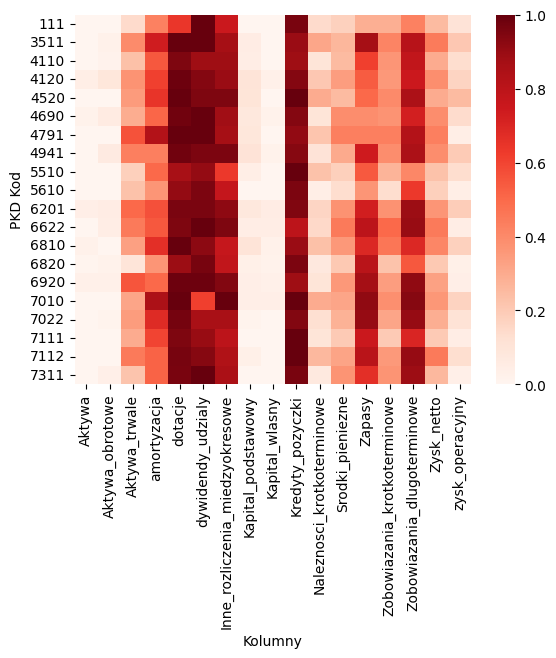

In [238]:
sns.heatmap(zeros_na_ratio_top, cmap='Reds')
plt.xlabel('Kolumny')
plt.ylabel('PKD Kod')
plt.show()

##### Nie widać specjalnej zależności

In [239]:
miss = df_train.isna().sum().sort_values(ascending=False)
miss[miss > 0]

RP_przeplywy_operacyjne             2077
wsk_pokrycie_zob_kr_gotowkowe_2     2077
wsk_zadluzenia_gotowki_2            2077
wsk_akt_generowania_got_2           2077
wsk_pokrycie_wyd_fin_gotowkowe_2    2077
wsk_zysk_CF_operacyjny              2077
RP_amortyzacja                      2018
wsk_plynnosc_biez_1                   65
wsk_kapital_do_aktywa                 29
wsk_struktura_kap_wlasnego_s_2        29
dtype: int64

##### Dane do usunięcia:
wsk_pokrycie_zob_kr_gotowkowe_2     2077

wsk_zadluzenia_gotowki_2            2077

wsk_akt_generowania_got_2           2077

wsk_pokrycie_wyd_fin_gotowkowe_2    2077

wsk_zysk_CF_operacyjny              2077

Te 5 kolumn równe zero najpewniej dlatego, że RP_przeplywy operacyjne, RP_amortyzacja równe 0 - przepływy operacyjne z tymi kolumnami potencjalnie do usunięcia.



#### Wartości inf

In [240]:
numeric_cols = df_train.select_dtypes(include=[np.number])

inf_counts = np.isinf(numeric_cols).sum()

inf_counts[inf_counts > 0]


wsk_kapital_do_aktywa               4
wsk_plynnosc_biez_1               640
wsk_struktura_kap_wlasnego_s_2     73
dtype: int64

In [241]:
df_train["wsk_kapital_do_aktywa"].describe()

count    2071.000000
mean             inf
std              NaN
min        -0.535175
25%         0.352406
50%         0.667487
75%         0.912225
max              inf
Name: wsk_kapital_do_aktywa, dtype: float64

In [242]:
(df_train["Aktywa"] == 0).sum()

np.int64(33)

In [243]:
print((df_train["Kapital_wlasny"] == 0).sum(), (df_train["Zobowiazania_krotkoterminowe"] == 0).sum())


48 708


##### Wszystkie inf/nan we wskaznikach biorą się z braków odpowiadających im danych

In [244]:
threshold = 0.5

numeric_cols = df_train.select_dtypes(include=['number']).columns

zero_percentage = (df_train[numeric_cols] == 0).sum() / len(df_train)

cols_many_zeros = zero_percentage[zero_percentage > threshold].index.tolist()

cols_many_zeros = [col for col in cols_many_zeros 
                   if not col.startswith('wsk') 
                   and col != 'pkdKod' 
                   and col != 'default']
print(len(cols_many_zeros))

54


### Wyznaczenie kolumn do imputacji danych brakujących

In [245]:
manual_cols = ['szczegolnaFormaPrawna_Symbol', 'RP_przeplywy_operacyjne', 'RP_amortyzacja', 'wsk_pokrycie_zob_kr_gotowkowe_2', 'wsk_zadluzenia_gotowki_2', 'wsk_akt_generowania_got_2', 'wsk_pokrycie_wyd_fin_gotowkowe_2', 'wsk_zysk_CF_operacyjny', 'schemat_wsk_bilans']
to_remove = manual_cols + cols_many_zeros
len(to_remove)

63

In [246]:

df_train = df_train.drop(columns=to_remove)

In [247]:
all_cols = df_train.columns

cols_not_wsk = [col for col in all_cols if not col.startswith('wsk')]

cols_not_wsk

['formaWlasnosci_Symbol',
 'pkdKod',
 'Aktywa',
 'Aktywa_trwale',
 'Aktywa_obrotowe',
 'Naleznosci_krotkoterminowe',
 'Inwestycje_krotkoterminowe',
 'Srodki_pieniezne',
 'Kapital_wlasny',
 'Kapital_podstawowy',
 'Zysk_netto',
 'Zobowiazania_rezerwy',
 'Zobowiazania_krotkoterminowe',
 'przychody_sprzedazy',
 'zysk_sprzedazy',
 'pozostale_przychody_oper',
 'koszty_operacyjne_pozostale',
 'zysk_operacyjny',
 'koszty_finansowe',
 'zysk_brutto',
 'podatek_dochodowy',
 'zysk_netto',
 'koszty_operacyjne',
 'schemat_wsk_rzis',
 'przychody',
 'default']

In [248]:
n_rows = len(df_train)
cols_5_50_percent = []
for col in cols_not_wsk:
    missing_ratio = ((df_train[col].isna()) | (df_train[col] == 0)).sum() / n_rows
    if 0.05 <= missing_ratio <= 0.5:
        cols_5_50_percent.append(col)

print("Kolumny z 5-50% braków (NaN lub 0):")
print(cols_5_50_percent)

Kolumny z 5-50% braków (NaN lub 0):
['formaWlasnosci_Symbol', 'Aktywa_trwale', 'Naleznosci_krotkoterminowe', 'Inwestycje_krotkoterminowe', 'Srodki_pieniezne', 'Kapital_podstawowy', 'Zysk_netto', 'Zobowiazania_rezerwy', 'Zobowiazania_krotkoterminowe', 'przychody_sprzedazy', 'zysk_sprzedazy', 'pozostale_przychody_oper', 'koszty_operacyjne_pozostale', 'zysk_operacyjny', 'koszty_finansowe', 'zysk_brutto', 'podatek_dochodowy', 'zysk_netto', 'koszty_operacyjne', 'przychody']


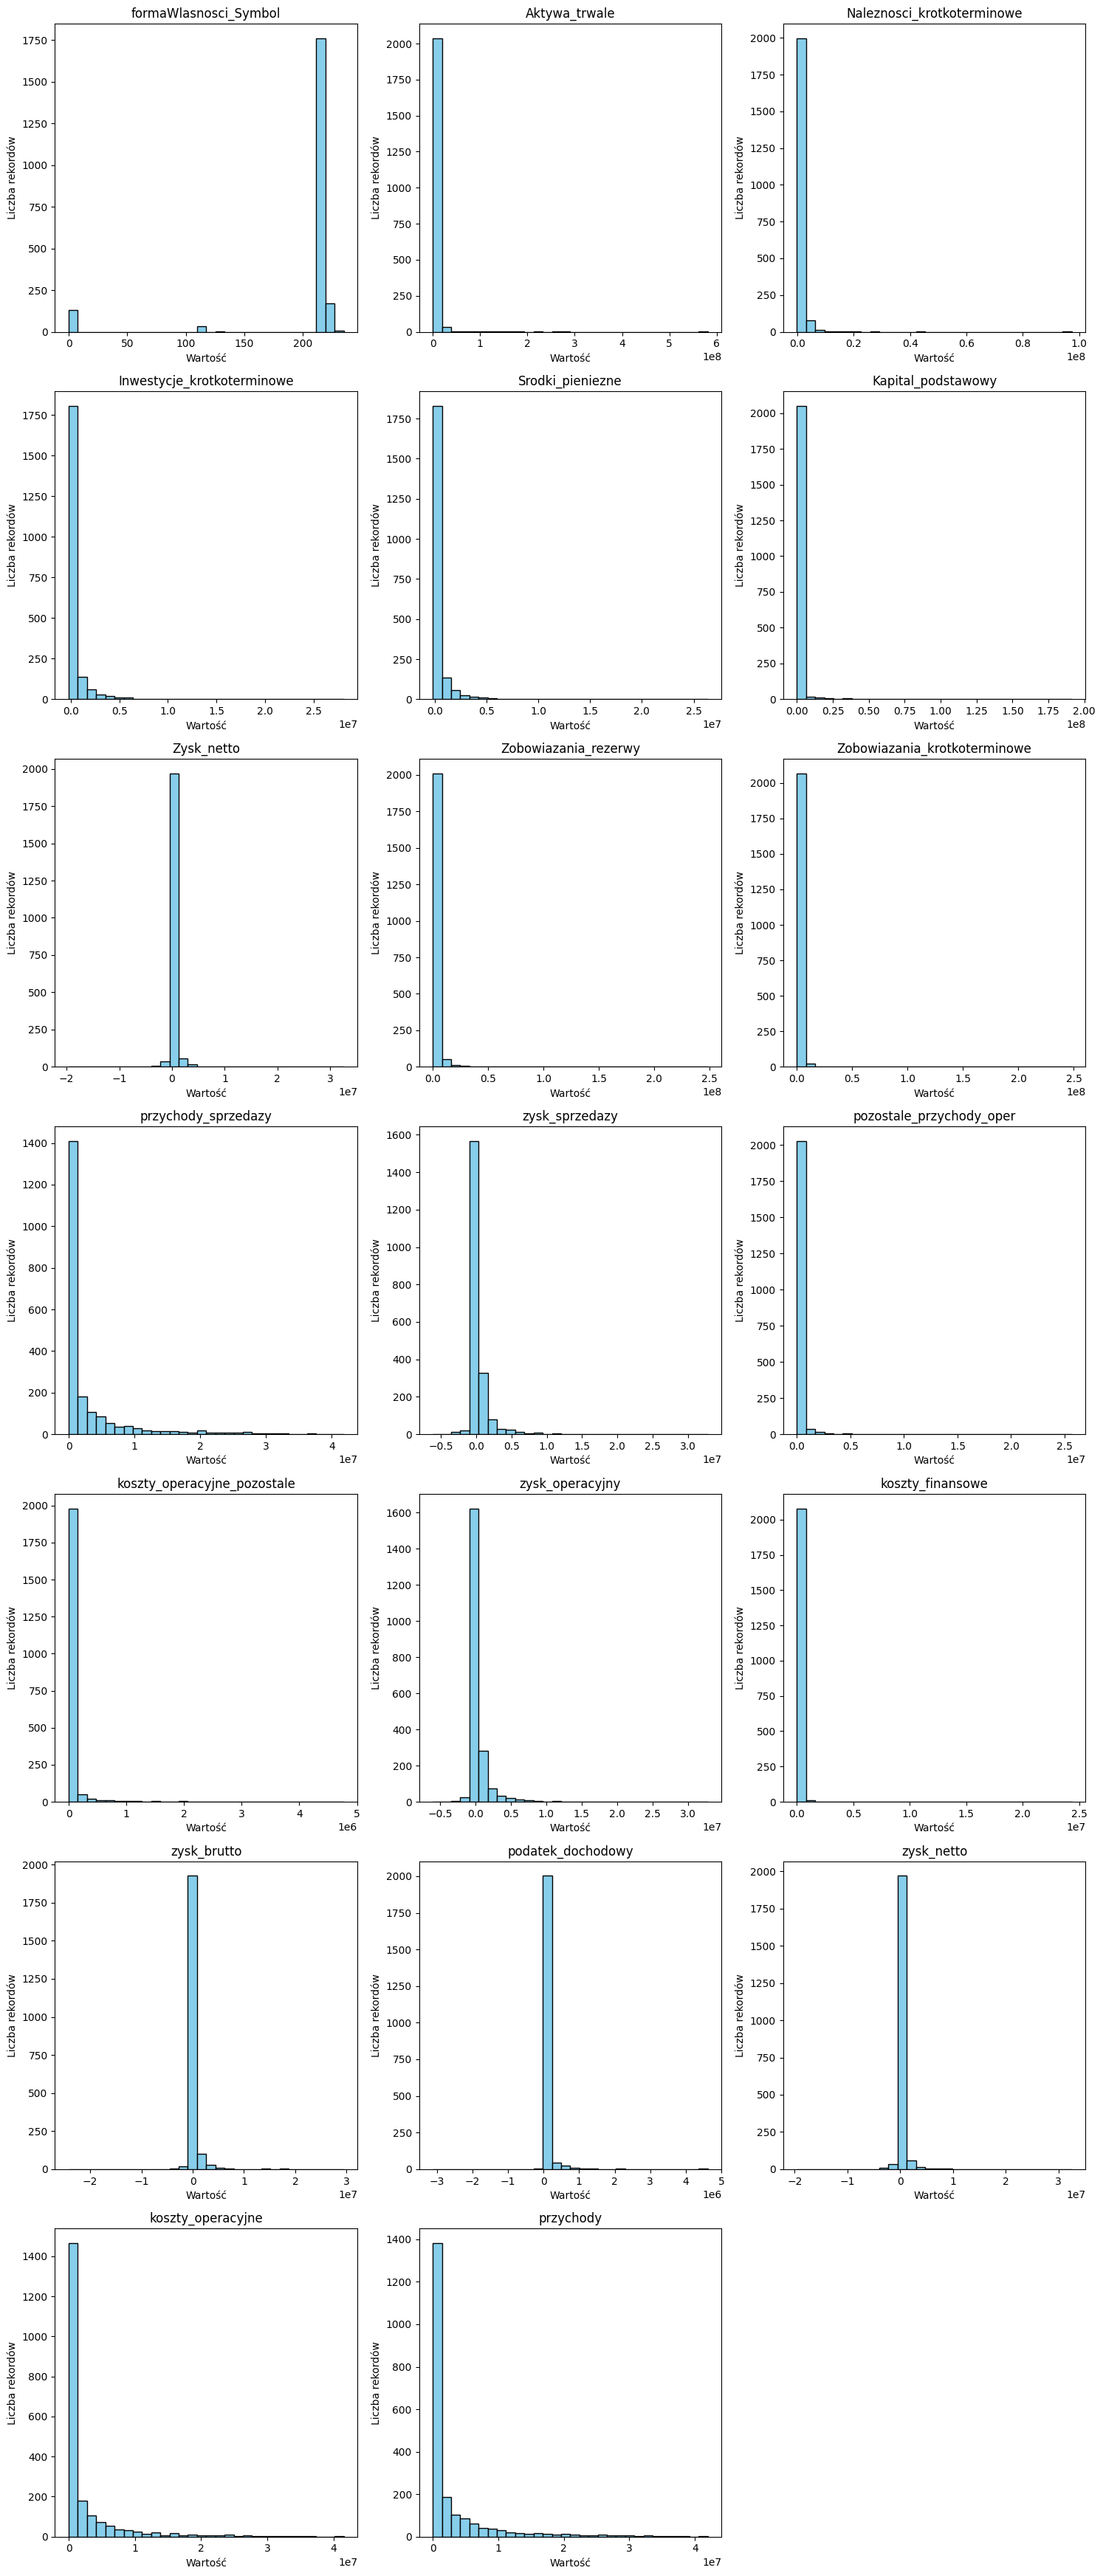

In [249]:
n_cols = len(cols_5_50_percent)
n_rows = (n_cols // 3) + 1 

fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5*n_rows))
axes = axes.flatten()

for i, col in enumerate(cols_5_50_percent):
    axes[i].hist(df_train[col].dropna(), bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_xlabel('Wartość')
    axes[i].set_ylabel('Liczba rekordów')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

##### Rozkłady skośne - do imputacji lepsza może być mediana

##### Kolumny ze wskaźnikami, które mają 0/nan

In [250]:
wsk_cols = [col for col in df_train.columns if col.startswith('wsk')]

wsk_cols_with_issues = [col for col in wsk_cols 
                        if df_train[col].isna().any() or (df_train[col] == 0).any()]

In [251]:
len(wsk_cols_with_issues)

130

#### Trzeba sprawdzić, które wskaźniki można uzupełnić po zaimputowaniu kolumn medianą; pozostałe do usunięcia

In [252]:
cols_to_impute = [
    'Aktywa', 'Aktywa_trwale', 'Aktywa_obrotowe', 'Naleznosci_krotkoterminowe',
    'Inwestycje_krotkoterminowe', 'Srodki_pieniezne', 'Kapital_wlasny', 'Kapital_podstawowy',
    'Zysk_netto', 'Zobowiazania_rezerwy', 'Zobowiazania_krotkoterminowe',
    'przychody_sprzedazy', 'zysk_sprzedazy', 'pozostale_przychody_oper', 'koszty_operacyjne_pozostale',
    'zysk_operacyjny', 'koszty_finansowe', 'zysk_brutto', 'podatek_dochodowy',
]

for col in cols_to_impute:
    median_val = df_train.loc[df_train[col] != 0, col].median()
    df_train[col] = df_train[col].replace(0, np.nan)     
    df_train[col].fillna(median_val, inplace=True)  

mode_val = df_train['formaWlasnosci_Symbol'].mode()[0]
df_train['formaWlasnosci_Symbol'].fillna(mode_val, inplace=True)

In [253]:
groups = {
    '<5%': [],
    '5-20%': [],
    '20-50%': [],
    '>50%': []
}


### Podejście do wskaźników - z powodu imputowania wartości niebędących wskaźnikami medianą liczenie na nowo wskaźników wydaje się być bez sensu - uzupełnimy je medianą

In [254]:
percent_missing = (
    ((df_train[wsk_cols].isna() | (df_train[wsk_cols] == 0) | (df_train[wsk_cols] == np.inf)).sum() / len(df_train)) * 100
)

for col, pct in percent_missing.items():
    if pct < 5:
        groups['<5%'].append(col)
    elif pct < 20:
        groups['5-20%'].append(col)
    elif pct < 50:
        groups['20-50%'].append(col)
    else:
        groups['>50%'].append(col)

In [255]:
{k: len(v) for k, v in groups.items()}

{'<5%': 24, '5-20%': 35, '20-50%': 57, '>50%': 15}

#### Sprawdzenie które z kolumn 20-50% mają wysokie korelacje z targetem - potencjalnie do zachowania

In [256]:
cols_20_50 = groups['20-50%']

In [257]:
correlations = df_train[cols_20_50 + ['default']].corr()['default'].drop('default')

sorted_correlations = correlations.reindex(correlations.abs().sort_values(ascending=False).index)

print(sorted_correlations)

wsk_udzial_zob_biez_aktywa_1              0.064611
wsk_marza_brutto_1                       -0.062182
wsk_marza_ebitda_2                       -0.061692
wsk_obrotowosc_gotowkowa                 -0.044701
wsk_ebitda_1                             -0.041054
wsk_ebitda_2                             -0.040659
wsk_Zobowiazania_krotkoterminowe          0.037191
wsk_ebit                                 -0.032188
wsk_rotacja_zobowiazan_dostaw_uslug       0.026871
wsk_Zobowiazania_dlugoterminowe           0.025404
wsk_zadluzenia_krotkie                    0.023411
wsk_zysk_zobowiazania                    -0.019087
wsk_rent_kaptial_podstawowy              -0.018462
wsk_rotacja_aktywow_1                    -0.018339
wsk_rotacja_naleznosci_dostaw_uslug      -0.017755
wsk_zysk_ebitda_3                        -0.017051
wsk_udzial_zob_biez_sprzedaz_1            0.016492
wsk_rotacja_zobowiazan                    0.016433
wsk_ROE_brutto                           -0.015829
wsk_rotacja_wartosci_niewateria

##### Żadna korelacja nie jest wysoka - można je usunąć

In [258]:
for group in ['<5%', '5-20%']:
    for col in groups[group]:
        if col in df_train.columns:
            median_value = df_train[col].median()
            df_train.replace([np.inf, -np.inf], np.nan, inplace=True)
            df_train[col].fillna(median_value, inplace=True)

cols_to_drop = groups['20-50%'] + groups['>50%']
df_train.drop(columns=[col for col in cols_to_drop if col in df_train.columns], inplace=True)
df_train

,formaWlasnosci_Symbol,pkdKod,wsk_liczba_dni_istnienia,Aktywa,Aktywa_trwale,Aktywa_obrotowe,Naleznosci_krotkoterminowe,Inwestycje_krotkoterminowe,Srodki_pieniezne,Kapital_wlasny,...,wsk_sytuacji_fin,wsk_struktura_kap_wlasnego_1,wsk_struktura_kap_wlasnego_2,wsk_struktura_kap_wlasnego_s_1,wsk_struktura_kap_wlasnego_s_2,wsk_zadluzenia,wsk_struktura_kap_obcego_s,wsk_zob_s_aktywa_rzeczowe,wsk_fin_majatku_kapitalem,default
904,214,4729,3662,91107.04,212043.35,91107.04,21954.74,54328.97,54328.970,45448.56,...,0.009954,0.498848,0.498848,0.498848,1.235752,1.004619,0.501152,-0.095168,0.498848,0
1715,216,4799,7638,10597590.84,542791.59,10054799.25,2929930.76,4840509.49,4840509.490,9194640.66,...,121.403947,0.867616,0.867616,0.867616,1.597101,0.152583,0.132384,-0.324372,0.860470,0
1449,214,4120,8455,6749456.93,1065720.31,5683736.62,63255.08,5116154.75,5116154.750,5521951.70,...,23.991641,0.818133,0.818133,0.818133,3.380851,0.222296,0.181867,-0.576143,0.784032,0
894,214,6820,2757,1865470.78,1813940.28,51530.50,32796.23,13146.96,13146.960,136454.70,...,0.002242,0.073148,0.073148,0.073148,0.073667,12.670990,0.926852,0.919805,-32.553256,0
1575,215,4110,1406,29969051.69,24511766.18,5457285.51,2127734.63,3192963.03,3192963.030,15279609.67,...,0.231584,0.509846,0.509846,0.509846,0.570644,0.961375,0.490154,0.383612,-1.691712,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
920,214,6920,1651,322516.81,212043.35,322516.81,39636.13,114666.09,114666.090,120009.92,...,0.005926,0.372104,0.372104,0.372104,0.577385,1.687418,0.627896,0.272360,0.372104,0
2480,214,6499,1671,323971.15,600.00,323371.15,232425.00,118876.75,101457.225,155095.15,...,494.971626,0.478731,0.478731,0.478731,0.478731,1.088854,0.521269,0.521269,0.477764,0
748,214,6312,2618,117059.94,212043.35,117059.94,123.00,116936.94,597.910,50955.75,...,0.007708,0.435296,0.435296,0.435296,0.437531,1.297286,0.564704,-0.434245,0.435296,0
2866,216,4647,1826,2698161.13,34.67,2698126.46,380212.74,32785.06,32785.060,1180432.27,...,60527.862924,0.437495,0.437495,0.437495,0.442876,1.285740,0.562505,0.550354,0.437488,0


#### Spliting categorical and numerical columns

In [259]:
cat_cols = ['formaWlasnosci_Symbol', 'pkdKod', 'schemat_wsk_rzis'] 

num_cols = [col for col in df_train.columns if col not in cat_cols]

cat_cols.append('default')

In [260]:
df_num = df_train[num_cols].copy()
df_cat = df_train[cat_cols].copy()

#### Outlier capping - IQR method

In [261]:
cols_to_cap = df_num.select_dtypes(include='number').columns.tolist()

for col in cols_to_cap:
    Q1 = df_train[col].quantile(0.25)
    Q3 = df_train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    below = (df_train[col] < lower).sum()
    above = (df_train[col] > upper).sum()
    
    print(f"{col}: {below} poniżej, {above} powyżej ")

wsk_liczba_dni_istnienia: 0 poniżej, 58 powyżej 
Aktywa: 0 poniżej, 290 powyżej 
Aktywa_trwale: 0 poniżej, 385 powyżej 
Aktywa_obrotowe: 0 poniżej, 281 powyżej 
Naleznosci_krotkoterminowe: 0 poniżej, 287 powyżej 
Inwestycje_krotkoterminowe: 0 poniżej, 332 powyżej 
Srodki_pieniezne: 0 poniżej, 324 powyżej 
Kapital_wlasny: 0 poniżej, 303 powyżej 
Kapital_podstawowy: 0 poniżej, 368 powyżej 
Zysk_netto: 132 poniżej, 359 powyżej 
Zobowiazania_rezerwy: 0 poniżej, 300 powyżej 
Zobowiazania_krotkoterminowe: 0 poniżej, 345 powyżej 
wsk_kapital_do_aktywa: 1 poniżej, 6 powyżej 
przychody_sprzedazy: 0 poniżej, 287 powyżej 
zysk_sprzedazy: 73 poniżej, 318 powyżej 
pozostale_przychody_oper: 0 poniżej, 368 powyżej 
koszty_operacyjne_pozostale: 0 poniżej, 368 powyżej 
zysk_operacyjny: 44 poniżej, 291 powyżej 
koszty_finansowe: 478 poniżej, 491 powyżej 
zysk_brutto: 115 poniżej, 361 powyżej 
podatek_dochodowy: 282 poniżej, 455 powyżej 
zysk_netto: 125 poniżej, 347 powyżej 
koszty_operacyjne: 0 poniżej,

##### Rozkład jest mocno skośny - w większości przypadków więcej do usunięcia większych wartości niż mniejszych
Wykryjmy kolumny mocno skośne - w celu transformacji logarytmicznej

In [262]:
skew_values = df_num.skew()
high_skew_cols = skew_values[(skew_values > 2)].index.tolist()

print("Mocno skośne kolumny:", len(high_skew_cols)/df_num.shape[1])
print(high_skew_cols)
high_skew_cols.remove('default')

Mocno skośne kolumny: 0.8902439024390244
['Aktywa', 'Aktywa_trwale', 'Aktywa_obrotowe', 'Naleznosci_krotkoterminowe', 'Inwestycje_krotkoterminowe', 'Srodki_pieniezne', 'Kapital_wlasny', 'Kapital_podstawowy', 'Zysk_netto', 'Zobowiazania_rezerwy', 'Zobowiazania_krotkoterminowe', 'wsk_kapital_do_aktywa', 'przychody_sprzedazy', 'zysk_sprzedazy', 'pozostale_przychody_oper', 'koszty_operacyjne_pozostale', 'zysk_operacyjny', 'koszty_finansowe', 'zysk_brutto', 'podatek_dochodowy', 'zysk_netto', 'koszty_operacyjne', 'przychody', 'wsk_koszty_operacyjne', 'wsk_rent_operacyjna_aktywow', 'wsk_mnoznik_kap_wl', 'wsk_zwrot_aktywa_trwale', 'wsk_akt_generowania_got_1', 'wsk_ebitda_3', 'wsk_marza_ebitda_3', 'wsk_ebitda_aktywa_3', 'wsk_zwrot_aktywa_mat', 'wsk_zysk_op_zobowiazania', 'wsk_koszty_przychody', 'wsk_pokrycie_wyd_fin_gotowkowe_1', 'wsk_pokrycie_aktywow_tr_kapitalem_st', 'wsk_struktury_finansowania', 'wsk_pokrycie_zob_kr_gotowkowe_1', 'wsk_zysk_operacyjny_zob_1', 'wsk_zysk_operacyjny_zob_2', 'wsk

#### Log-transformacja i powrót do outlier policy 

Pytanie: czy dobrze uśredniać aż tyle outlierów do poprzedniej wartości?

In [263]:
for col in high_skew_cols:
    min_val = df_num[col].min()
    df_num[col] = df_num[col] + abs(min_val) + 1
    df_num[col] = np.log(df_num[col])

nan_percentage = df_num.isna().mean() * 100
nan_percentage


wsk_liczba_dni_istnienia      0.0
Aktywa                        0.0
Aktywa_trwale                 0.0
Aktywa_obrotowe               0.0
Naleznosci_krotkoterminowe    0.0
                             ... 
wsk_zadluzenia                0.0
wsk_struktura_kap_obcego_s    0.0
wsk_zob_s_aktywa_rzeczowe     0.0
wsk_fin_majatku_kapitalem     0.0
default                       0.0
Length: 82, dtype: float64

In [264]:
for col in df_num.columns:
    Q1 = df_num[col].quantile(0.25)
    Q3 = df_num[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    below = (df_num[col] < lower).sum()
    above = (df_num[col] > upper).sum()
    
    print(f"{col}: {below} poniżej, {above} powyżej ")

wsk_liczba_dni_istnienia: 0 poniżej, 58 powyżej 
Aktywa: 1 poniżej, 7 powyżej 
Aktywa_trwale: 1 poniżej, 99 powyżej 
Aktywa_obrotowe: 1 poniżej, 1 powyżej 
Naleznosci_krotkoterminowe: 1 poniżej, 59 powyżej 
Inwestycje_krotkoterminowe: 1 poniżej, 225 powyżej 
Srodki_pieniezne: 1 poniżej, 244 powyżej 
Kapital_wlasny: 5 poniżej, 4 powyżej 
Kapital_podstawowy: 0 poniżej, 41 powyżej 
Zysk_netto: 132 poniżej, 358 powyżej 
Zobowiazania_rezerwy: 1 poniżej, 34 powyżej 
Zobowiazania_krotkoterminowe: 1 poniżej, 132 powyżej 
wsk_kapital_do_aktywa: 1 poniżej, 5 powyżej 
przychody_sprzedazy: 106 poniżej, 0 powyżej 
zysk_sprzedazy: 73 poniżej, 315 powyżej 
pozostale_przychody_oper: 1 poniżej, 198 powyżej 
koszty_operacyjne_pozostale: 298 poniżej, 57 powyżej 
zysk_operacyjny: 46 poniżej, 283 powyżej 
koszty_finansowe: 489 poniżej, 484 powyżej 
zysk_brutto: 116 poniżej, 360 powyżej 
podatek_dochodowy: 283 poniżej, 455 powyżej 
zysk_netto: 127 poniżej, 347 powyżej 
koszty_operacyjne: 0 poniżej, 0 powyże

#### Outlier policy:
- dla kolumn bez outlierów IQR bez zmian
- dla standardowych kolumn (<10% outlierów) capping 1.5xIQR
- dla ekstremalnych kolumn >10% danych to outliery - 1/99 percentyle

In [265]:
num_cols = [col for col in df_num.columns if col != 'default']

no_cap_cols = []
moderate_iqr_cols = []
percentile_cols = []

for col in num_cols:
    Q1 = df_num[col].quantile(0.25)
    Q3 = df_num[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_1_5 = Q1 - 1.5 * IQR
    upper_1_5 = Q3 + 1.5 * IQR
    
    below = (df_num[col] < lower_1_5).sum()
    above = (df_num[col] > upper_1_5).sum()
    perc_outliers = (below + above) / len(df_num[col])
    
    if perc_outliers == 0:
        no_cap_cols.append(col)
    elif perc_outliers <= 0.1:
        moderate_iqr_cols.append(col)
    else:
        percentile_cols.append(col)

In [266]:
for col in moderate_iqr_cols:
    Q1 = df_num[col].quantile(0.25)
    Q3 = df_num[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df_num[col] = df_num[col].clip(lower=lower, upper=upper)

for col in percentile_cols:
    lower = df_num[col].quantile(0.01)
    upper = df_num[col].quantile(0.99)
    df_num[col] = df_num[col].clip(lower=lower, upper=upper)
    
# Procent brakujących wartości w każdej kolumnie
nan_percentage = df_num.isna().mean() * 100
nan_percentage

wsk_liczba_dni_istnienia      0.0
Aktywa                        0.0
Aktywa_trwale                 0.0
Aktywa_obrotowe               0.0
Naleznosci_krotkoterminowe    0.0
                             ... 
wsk_zadluzenia                0.0
wsk_struktura_kap_obcego_s    0.0
wsk_zob_s_aktywa_rzeczowe     0.0
wsk_fin_majatku_kapitalem     0.0
default                       0.0
Length: 82, dtype: float64

In [267]:
corr_with_target = df_num.corr()['default'].sort_values(ascending=False)

print(corr_with_target)

default                        1.000000
wsk_zadluzenia                 0.154566
wsk_zadluzenie_kap_wlasnego    0.154516
wsk_struktura_kap_obcego_s     0.117854
wsk_mnoznik_kap_wl             0.116355
                                 ...   
Aktywa                        -0.108611
wsk_kapital_do_aktywa         -0.110314
wsk_akt_generowania_got_1     -0.113871
Aktywa_obrotowe               -0.121481
Kapital_wlasny                -0.175126
Name: default, Length: 82, dtype: float64


### Iteracyjne usuwanie skorelowanych kolumn

In [268]:
df_num

,wsk_liczba_dni_istnienia,Aktywa,Aktywa_trwale,Aktywa_obrotowe,Naleznosci_krotkoterminowe,Inwestycje_krotkoterminowe,Srodki_pieniezne,Kapital_wlasny,Kapital_podstawowy,Zysk_netto,...,wsk_sytuacji_fin,wsk_struktura_kap_wlasnego_1,wsk_struktura_kap_wlasnego_2,wsk_struktura_kap_wlasnego_s_1,wsk_struktura_kap_wlasnego_s_2,wsk_zadluzenia,wsk_struktura_kap_obcego_s,wsk_zob_s_aktywa_rzeczowe,wsk_fin_majatku_kapitalem,default
904,3662.0,11.974238,12.292380,11.974238,12.128902,12.448512,12.448512,10.724745,10.310318,16.791094,...,7.345210,0.710015,0.710015,1.036287,1.278750,1.583744,0.621386,-0.095168,0.498848,0
1715,7638.0,16.182487,13.215447,16.130252,14.944692,15.433125,15.433125,16.034133,15.645856,16.931542,...,7.420672,0.876631,0.876631,1.159237,1.374600,1.391564,0.400613,-0.324372,0.860470,0
1449,8455.0,15.734925,13.884762,15.564927,12.330265,15.486363,15.486363,15.524245,11.002783,16.870231,...,7.360576,0.855822,0.855822,1.143591,1.746979,1.408751,0.433224,-0.576143,0.784032,0
894,2757.0,14.474573,14.414306,11.687206,12.185808,12.272276,12.272276,11.823884,12.899322,16.790206,...,7.345205,0.475192,0.475192,0.872560,0.887917,2.241850,0.827332,0.919805,-32.553256,0
1575,1406.0,17.217926,16.152049,15.524757,14.644467,15.037374,15.037374,16.542031,8.535230,16.836314,...,7.345354,0.715408,0.715408,1.040181,1.073991,1.574831,0.615461,0.383612,-1.691712,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
920,1651.0,12.873967,12.292380,12.873967,12.220113,12.660987,12.660987,11.695484,9.618535,16.794649,...,7.345208,0.645678,0.645678,0.990280,1.076292,1.714872,0.687255,0.272360,0.372104,0
2480,1671.0,12.877689,8.792550,12.876155,12.888201,12.674257,12.618179,11.951914,11.290294,16.792349,...,7.622528,0.700076,0.700076,1.029124,1.042086,1.600882,0.632135,0.521269,0.477764,0
748,2618.0,12.125775,12.292380,12.125775,12.003434,12.668166,12.211755,10.839077,8.525360,16.791224,...,7.345209,0.678273,0.678273,1.013482,1.027448,1.642067,0.654956,-0.434245,0.435296,0
2866,1826.0,14.832793,8.702788,14.832781,13.205609,12.360195,12.360195,13.981407,12.206278,16.795474,...,9.788294,0.679388,0.679388,1.014280,1.029359,1.639829,0.653814,0.550354,0.437488,0


In [269]:
threshold = 0.8

df_reduced = df_num.drop(columns=["default"]).copy()
df_reduced=df_reduced[df_reduced.columns.sort_values()]

while True:
    corr_matrix = df_reduced.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop_pairs = [(col1, col2) for col1 in upper.columns for col2 in upper.index
                    if pd.notnull(upper.loc[col1, col2]) and upper.loc[col1, col2] > threshold]
    
    if not to_drop_pairs:
        break  

    freq = {}
    for col1, col2 in to_drop_pairs:
        freq[col1] = freq.get(col1, 0) + 1
        freq[col2] = freq.get(col2, 0) + 1

    max_freq = max(freq.values())
    max_cols = [col for col, f in freq.items() if f == max_freq]
    col_to_drop = sorted(max_cols)[-1]  # ostatnia alfabetycznie

    
    #print(f"Usuwam kolumnę: {col_to_drop} (najczęściej występująca w parach z korelacją > {threshold})")
    df_reduced = df_reduced.drop(columns=[col_to_drop])
    
df_num =df_num[df_reduced.columns.tolist() + ['default']]
df_num.columns

Index(['Aktywa_obrotowe', 'Aktywa_trwale', 'Inwestycje_krotkoterminowe',
       'Kapital_podstawowy', 'Kapital_wlasny', 'Zobowiazania_krotkoterminowe',
       'Zysk_netto', 'koszty_finansowe', 'koszty_operacyjne',
       'koszty_operacyjne_pozostale', 'podatek_dochodowy',
       'pozostale_przychody_oper', 'przychody', 'przychody_sprzedazy',
       'wsk_akt_generowania_got_1', 'wsk_cykl_konwersji_gotowki',
       'wsk_ebitda_3', 'wsk_ebitda_aktywa_3', 'wsk_ebitda_koszty_finansowe_3',
       'wsk_ebitda_koszty_odsetkowe_3', 'wsk_ebitda_zobowiazan_3',
       'wsk_ebitda_zobowiazan_odsetki_3', 'wsk_fin_majatku_kapitalem',
       'wsk_kapital_do_aktywa', 'wsk_koszty_przychody',
       'wsk_liczba_dni_istnienia', 'wsk_marza_ebitda_3', 'wsk_mnoznik_kap_wl',
       'wsk_plynnosc_biez_2', 'wsk_pokrycie_aktywow_kap_stalym',
       'wsk_pokrycie_wyd_fin_gotowkowe_1', 'wsk_pokrycie_zob_kr_gotowkowe_1',
       'wsk_poziom_kapitalu_obrotowego_netto', 'wsk_rent_operacyjna',
       'wsk_rotacja_nalez

In [270]:
# --- 1. Połącz dane ---
data_full = pd.concat([df_num.drop(columns=['default']), df_cat], axis=1)

# --- 2. BINNING zmiennych numerycznych ---
data_binned = data_full.copy()

N_BINS = 5  # pożądana liczba przedziałów

for col in df_num.columns:
    if col == 'default':
        continue

    s = data_full[col].replace([np.inf, -np.inf], np.nan).dropna()

    # jeśli za mało unikalnych wartości – pomiń binning
    if s.nunique() < 2:
        data_binned[col] = data_full[col]
        continue

    # próbuj utworzyć tyle binów, ile się da
    bins_found = False
    for q in range(N_BINS, 1, -1):
        try:
            _, bins = pd.qcut(s, q=q, retbins=True, duplicates='drop')

            # Rozszerz zakres binów, żeby żadne wartości nie wypadły
            bins[0] = -np.inf
            bins[-1] = np.inf

            # Przypisz zbinowane wartości
            data_binned[col] = pd.cut(
                data_full[col].replace([np.inf, -np.inf], np.nan),
                bins=bins,
                include_lowest=True
            )
            bins_found = True
            break

        except Exception as e:
            continue

    if not bins_found:
        print(f"⚠️ Nie udało się zbinować kolumny '{col}' — za mało unikalnych wartości.")
        data_binned[col] = data_full[col]

data_binned




,Aktywa_obrotowe,Aktywa_trwale,Inwestycje_krotkoterminowe,Kapital_podstawowy,Kapital_wlasny,Zobowiazania_krotkoterminowe,Zysk_netto,koszty_finansowe,koszty_operacyjne,koszty_operacyjne_pozostale,...,wsk_udzial_kapitalu_obrotowego_netto,wsk_udzial_zob_biez_sprzedaz_2,wsk_zast_kapitalu_obcego,wsk_zast_kapitalu_podstawowego,wsk_zob_s_aktywa_rzeczowe,wsk_zwrot_aktywa_trwale,formaWlasnosci_Symbol,pkdKod,schemat_wsk_rzis,default
904,"(11.559, 12.487]","(10.491, 12.292]","(12.333, 12.674]","(10.128, 10.821]","(10.286, 11.749]","(-inf, 11.808]","(16.791, 16.792]","(7.688, 8.804]","(11.518, 13.324]","(-inf, 5.604]",...,"(1.829, 1.878]","(12.996352, 12.9963524]","(0.616, 0.779]","(4.084, inf]","(-0.215, 0.0139]","(9.05179, 9.12071]",214,4729,SFJIN,0
1715,"(14.519, inf]","(12.292, 13.799]","(13.321, inf]","(12.206, inf]","(14.384, inf]","(13.68, inf]","(16.799, inf]","(9.669, inf]","(-inf, 6.571]","(9.771, inf]",...,"(1.878, 1.921]","(12.9963511, 12.996352]","(0.476, 0.616]","(2.702, 4.084]","(-inf, -0.215]","(9.05179, 9.12071]",216,4799,SFJMA,0
1449,"(14.519, inf]","(13.799, inf]","(13.321, inf]","(10.821, 12.206]","(14.384, inf]","(13.68, inf]","(16.799, inf]","(8.804, 9.669]","(15.006, inf]","(8.252, 9.771]",...,"(1.878, 1.921]","(12.9963511, 12.996352]","(0.476, 0.616]","(-inf, 2.243]","(-inf, -0.215]","(9.05179, 9.12071]",214,4120,SFJIN,0
894,"(11.559, 12.487]","(13.799, inf]","(-inf, 12.333]","(12.206, inf]","(11.749, 12.921]","(-inf, 11.808]","(-inf, 16.791]","(9.669, inf]","(11.518, 13.324]","(8.252, 9.771]",...,"(-inf, 1.78]","(12.996352, 12.9963524]","(0.93, inf]","(2.243, 2.3]","(0.575, inf]","(9.0509, 9.05091]",214,6820,SFJIN,0
1575,"(14.519, inf]","(13.799, inf]","(13.321, inf]","(8.525, 10.128]","(14.384, inf]","(13.68, inf]","(16.799, inf]","(9.669, inf]","(13.324, 15.006]","(9.771, inf]",...,"(1.78, 1.829]","(12.9963025, 12.9963511]","(0.93, inf]","(-inf, 2.243]","(0.274, 0.575]","(9.12071, inf]",215,4110,SFJIN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
920,"(12.487, 13.331]","(10.491, 12.292]","(12.333, 12.674]","(8.525, 10.128]","(10.286, 11.749]","(11.808, 12.665]","(16.792, 16.799]","(8.804, 9.669]","(13.324, 15.006]","(5.604, 8.252]",...,"(1.829, 1.878]","(12.9963511, 12.996352]","(0.779, 0.93]","(4.084, inf]","(0.0139, 0.274]","(9.12071, inf]",214,6920,SFJMA,0
2480,"(12.487, 13.331]","(-inf, 10.491]","(12.333, 12.674]","(10.821, 12.206]","(11.749, 12.921]","(11.808, 12.665]","(16.791, 16.792]","(7.688, 8.804]","(13.324, 15.006]","(8.252, 9.771]",...,"(1.921, inf]","(12.996352, 12.9963524]","(0.616, 0.779]","(4.084, inf]","(0.274, 0.575]","(9.12071, inf]",214,6499,SFJMI,0
748,"(11.559, 12.487]","(10.491, 12.292]","(12.333, 12.674]","(-inf, 8.525]","(10.286, 11.749]","(11.808, 12.665]","(16.791, 16.792]","(7.688, 8.804]","(6.571, 11.518]","(5.604, 8.252]",...,"(1.829, 1.878]","(-inf, 12.9963025]","(0.616, 0.779]","(2.702, 4.084]","(-inf, -0.215]","(-inf, 9.0509]",214,6312,SFJIN,0
2866,"(14.519, inf]","(-inf, 10.491]","(12.333, 12.674]","(10.821, 12.206]","(12.921, 14.384]","(13.68, inf]","(16.792, 16.799]","(8.804, 9.669]","(13.324, 15.006]","(-inf, 5.604]",...,"(1.829, 1.878]","(12.9963025, 12.9963511]","(0.616, 0.779]","(4.084, inf]","(0.274, 0.575]","(9.12071, inf]",216,4647,SFJIN,0


In [271]:
# --- 3. FUNKCJA DO OBLICZENIA WOE ---
def calc_woe(dataset, feature, target_col):
    grouped = dataset.groupby(feature)[target_col].agg(['count', 'sum'])
    grouped.columns = ['total', 'bad']
    grouped['good'] = grouped['total'] - grouped['bad']

    grouped['bad_dist'] = grouped['bad'] / grouped['bad'].sum()
    grouped['good_dist'] = grouped['good'] / grouped['good'].sum()

    grouped['woe'] = np.log((grouped['good_dist'] + 1e-6) / (grouped['bad_dist'] + 1e-6))
    return grouped['woe']

# --- 4. OBLICZENIE WOE DLA WSZYSTKICH ZMIENNYCH ---
woe_maps = {}
for col in data_binned.drop(columns=['default']).columns:
    woe_table = calc_woe(data_binned, col, 'default')
    woe_maps[col] = woe_table.to_dict()

# --- 5. ZAMIANA WARTOŚCI NA WOE ---
data_woe = data_binned.copy()
for col, mapping in woe_maps.items():
    data_woe[col] = data_binned[col].map(mapping)



In [272]:
data_woe=data_woe[sorted(data_woe.columns)]
data_woe

,Aktywa_obrotowe,Aktywa_trwale,Inwestycje_krotkoterminowe,Kapital_podstawowy,Kapital_wlasny,Zobowiazania_krotkoterminowe,Zysk_netto,default,formaWlasnosci_Symbol,koszty_finansowe,...,wsk_struktury_kapitalu,wsk_sytuacji_fin,wsk_udzial_kap_obrotowego_w_fin,wsk_udzial_kap_wlasnego_aktywa_2,wsk_udzial_kapitalu_obrotowego_netto,wsk_udzial_zob_biez_sprzedaz_2,wsk_zast_kapitalu_obcego,wsk_zast_kapitalu_podstawowego,wsk_zob_s_aktywa_rzeczowe,wsk_zwrot_aktywa_trwale
904,-0.294451,-0.106711,-0.107630,0.047029,-0.249811,-0.226909,-0.127189,0,0.022419,-0.123453,...,0.056542,-0.358726,0.027946,0.508715,0.278299,0.313656,0.597146,-0.175144,0.243976,-0.054067
1715,0.508715,0.262362,0.798225,0.502089,1.044536,0.387763,1.044536,0,-0.379485,0.426678,...,0.278299,0.466960,0.243976,0.508715,0.243976,0.597146,0.426678,-0.056292,0.000000,-0.054067
1449,0.508715,0.552065,0.798225,0.051293,1.044536,0.387763,1.044536,0,0.022419,0.173508,...,0.278299,0.115831,0.085825,0.508715,0.243976,0.597146,0.426678,0.000000,0.000000,-0.054067
894,-0.294451,0.552065,-0.535242,0.502089,0.146603,-0.226909,-0.535242,0,0.022419,0.426678,...,-0.725233,-0.358726,0.027946,-0.459530,-0.379488,0.313656,-0.358726,0.278299,-0.725233,-0.105892
1575,0.508715,0.552065,0.798225,-0.143836,1.044536,0.387763,1.044536,0,-0.048527,0.426678,...,0.056542,-0.186102,0.027946,0.508715,0.027946,-0.131028,-0.358726,0.000000,0.508715,0.027946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
920,-0.054067,-0.106711,-0.107630,-0.143836,-0.249811,-0.115761,0.510202,0,0.022419,0.173508,...,0.056542,-0.358726,0.278299,-0.459530,0.278299,0.597146,-0.337641,-0.175144,0.387763,0.027946
2480,-0.054067,-0.291738,-0.107630,0.051293,0.146603,-0.115761,-0.127189,0,0.022419,-0.123453,...,0.056542,0.466960,0.027946,0.508715,-0.054067,0.313656,0.597146,-0.175144,0.508715,0.027946
748,-0.294451,-0.106711,-0.107630,-0.236388,-0.249811,-0.115761,-0.127189,0,0.022419,-0.123453,...,0.056542,-0.358726,0.085825,0.056542,0.278299,-0.054067,0.597146,-0.056292,0.000000,-0.516689
2866,0.508715,-0.291738,-0.107630,0.051293,0.552065,0.387763,0.510202,0,-0.379485,0.173508,...,0.056542,0.466960,0.278299,0.056542,0.278299,-0.131028,0.597146,-0.175144,0.508715,0.027946


In [273]:
# Lista kolumn w kolejności alfabetycznej
columns_sorted = sorted(data_woe.columns.to_list())

# Wyświetlenie
print(columns_sorted)

['Aktywa_obrotowe', 'Aktywa_trwale', 'Inwestycje_krotkoterminowe', 'Kapital_podstawowy', 'Kapital_wlasny', 'Zobowiazania_krotkoterminowe', 'Zysk_netto', 'default', 'formaWlasnosci_Symbol', 'koszty_finansowe', 'koszty_operacyjne', 'koszty_operacyjne_pozostale', 'pkdKod', 'podatek_dochodowy', 'pozostale_przychody_oper', 'przychody', 'przychody_sprzedazy', 'schemat_wsk_rzis', 'wsk_akt_generowania_got_1', 'wsk_cykl_konwersji_gotowki', 'wsk_ebitda_3', 'wsk_ebitda_aktywa_3', 'wsk_ebitda_koszty_finansowe_3', 'wsk_ebitda_koszty_odsetkowe_3', 'wsk_ebitda_zobowiazan_3', 'wsk_ebitda_zobowiazan_odsetki_3', 'wsk_fin_majatku_kapitalem', 'wsk_kapital_do_aktywa', 'wsk_koszty_przychody', 'wsk_liczba_dni_istnienia', 'wsk_marza_ebitda_3', 'wsk_mnoznik_kap_wl', 'wsk_plynnosc_biez_2', 'wsk_pokrycie_aktywow_kap_stalym', 'wsk_pokrycie_wyd_fin_gotowkowe_1', 'wsk_pokrycie_zob_kr_gotowkowe_1', 'wsk_poziom_kapitalu_obrotowego_netto', 'wsk_rent_operacyjna', 'wsk_rotacja_naleznosci', 'wsk_struktura_kap_wlasnego_s_

#### Calculating IV to delete low important columns

In [274]:
def iv_from_woe_values(X, y):
    n_event = np.sum(y == 1)
    n_non = np.sum(y == 0)

    ivs = {}
    for col in X.columns:
        iv_sum = 0.0
        vals = np.unique(X[col])
        for val in vals:
            p_event = np.sum((X[col] == val) & (y == 1)) / n_event
            p_non_event = np.sum((X[col] == val) & (y == 0)) / n_non
            woe_val = float(val)    # zakładamy, że val to WOE
            iv_sum += (p_non_event - p_event) * woe_val
        ivs[col] = iv_sum
    return pd.Series(ivs).sort_values(ascending=False)


In [275]:
X = data_woe.drop(columns='default')
y = data_woe['default']
ivs = iv_from_woe_values(X,y)
ivs

pkdKod                                  3.460578
wsk_poziom_kapitalu_obrotowego_netto    0.423853
Kapital_wlasny                          0.358477
wsk_mnoznik_kap_wl                      0.273130
wsk_zwrot_aktywa_trwale                 0.266065
wsk_kapital_do_aktywa                   0.253277
Zysk_netto                              0.252067
wsk_struktury_kapitalu                  0.248801
wsk_zob_s_aktywa_rzeczowe               0.218946
wsk_struktura_kap_wlasnego_s_2          0.206172
Inwestycje_krotkoterminowe              0.204369
Aktywa_obrotowe                         0.200145
wsk_ebitda_3                            0.191499
formaWlasnosci_Symbol                   0.188911
wsk_ebitda_zobowiazan_odsetki_3         0.187293
koszty_operacyjne                       0.183336
wsk_ebitda_zobowiazan_3                 0.177469
wsk_akt_generowania_got_1               0.174468
wsk_pokrycie_zob_kr_gotowkowe_1         0.173615
przychody_sprzedazy                     0.171804
wsk_pokrycie_wyd_fin

#### pkdKod wygląda podejrzanie, pytanie co z nim. Usuwamy predyktory z wartościami mniejszymi od 0.1

In [276]:
X = X[ivs[ivs >= 0.1].index]

In [277]:
X = X.apply(pd.to_numeric, errors='coerce')
X

,pkdKod,wsk_poziom_kapitalu_obrotowego_netto,Kapital_wlasny,wsk_mnoznik_kap_wl,wsk_zwrot_aktywa_trwale,wsk_kapital_do_aktywa,Zysk_netto,wsk_struktury_kapitalu,wsk_zob_s_aktywa_rzeczowe,wsk_struktura_kap_wlasnego_s_2,...,wsk_ebitda_aktywa_3,wsk_fin_majatku_kapitalem,wsk_zast_kapitalu_obcego,wsk_plynnosc_biez_2,pozostale_przychody_oper,wsk_marza_ebitda_3,wsk_ebitda_koszty_odsetkowe_3,wsk_udzial_zob_biez_sprzedaz_2,wsk_rent_operacyjna,wsk_koszty_przychody
904,-1.557395,-0.375301,-0.249811,0.210624,-0.054067,0.210624,-0.127189,0.056542,0.243976,0.056542,...,0.146603,0.508715,0.597146,0.278299,-0.439949,0.381245,0.350118,0.313656,0.552065,0.210624
1715,7.875719,1.364515,1.044536,0.313656,-0.054067,0.313656,1.044536,0.278299,0.000000,0.056542,...,0.644113,0.508715,0.426678,0.085825,0.597146,0.350118,0.178184,0.597146,0.313656,0.552065
1449,-0.253189,1.364515,1.044536,0.313656,-0.054067,0.313656,1.044536,0.278299,0.000000,0.056542,...,0.644113,0.508715,0.426678,0.508715,0.514324,0.387763,0.426678,0.597146,0.313656,0.552065
894,0.616589,-0.375301,0.146603,-0.757364,-0.105892,-0.757364,-0.535242,-0.725233,-0.725233,-0.725233,...,0.146603,-0.378185,-0.358726,0.508715,-0.104191,0.350118,-0.019934,0.313656,0.313656,-0.179860
1575,-0.379478,1.364515,1.044536,0.210624,0.027946,0.210624,1.044536,0.056542,0.508715,0.387763,...,0.146603,-0.378185,-0.358726,0.278299,0.597146,0.350118,0.350118,-0.131028,0.313656,-0.179860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
920,0.552047,-0.179860,-0.249811,0.210624,0.027946,0.210624,0.510202,0.056542,0.387763,0.387763,...,0.644113,0.508715,-0.337641,0.278299,0.514324,0.387763,0.178184,0.597146,0.313656,0.552065
2480,-0.864906,0.744435,0.146603,0.210624,0.027946,0.210624,-0.127189,0.056542,0.508715,0.387763,...,0.115831,0.508715,0.597146,-0.027328,-0.104191,0.085825,0.426678,0.313656,0.027946,0.210624
748,-0.641764,-0.375301,-0.249811,0.210624,-0.516689,0.210624,-0.127189,0.056542,0.000000,0.387763,...,-0.431557,0.508715,0.597146,0.278299,-0.439949,-0.440417,-0.429835,-0.054067,-0.316220,-0.399939
2866,-0.641674,1.364515,0.552065,0.210624,0.027946,0.210624,0.510202,0.056542,0.508715,0.387763,...,0.146603,0.508715,0.597146,0.508715,0.514324,0.387763,0.350118,-0.131028,0.552065,0.210624


#### Czy wszystkie WoE są monotoniczne?

In [278]:
def plot_all_woe_monotonicity(X, y, bins=10):
    
    y_vals = pd.Series(y).reset_index(drop=True)
    for feature in X.columns:
        feat_vals = X[feature].reset_index(drop=True)
        df = pd.DataFrame({feature: feat_vals, "_y": y_vals}).dropna()

        if df[feature].nunique() > 4:
            try:
                binned = pd.qcut(df[feature], q=bins, duplicates='drop')
            except ValueError:
                continue
        else:
            binned = df[feature]

        grouped_rate = df.groupby(binned)["_y"].mean()
        mean_woe = df.groupby(binned)[feature].mean()

        plt.figure(figsize=(6,4))
        plt.plot(mean_woe, grouped_rate, marker='o')
        plt.title(feature)
        plt.xlabel('WOE (mean in bin)')
        plt.ylabel('Event rate')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

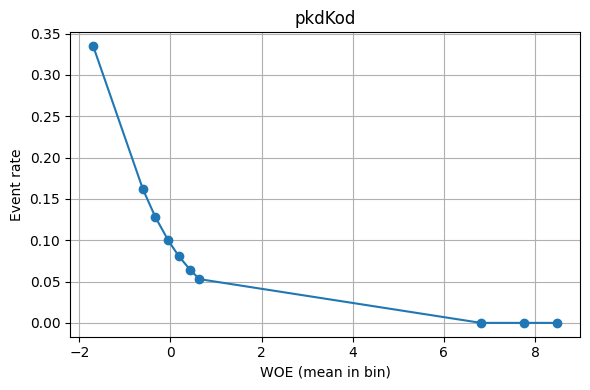

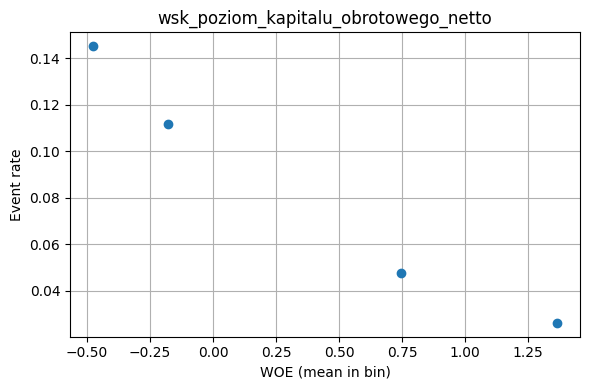

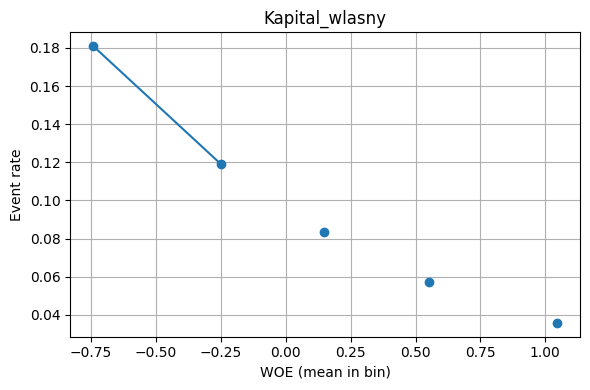

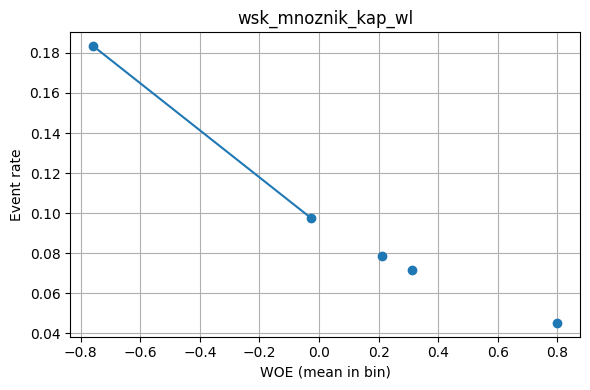

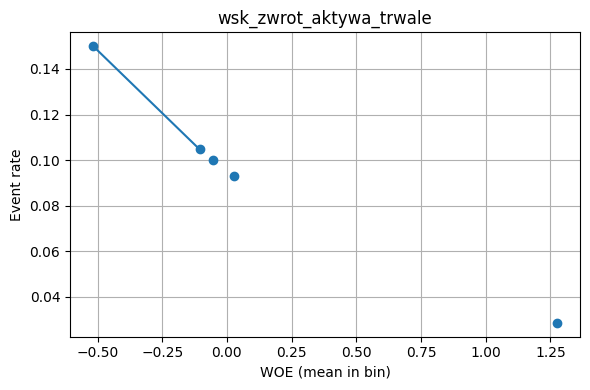

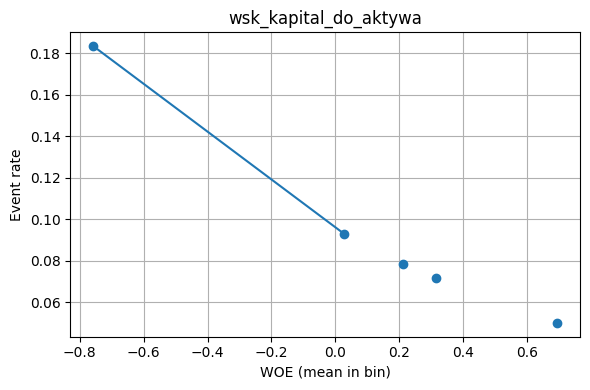

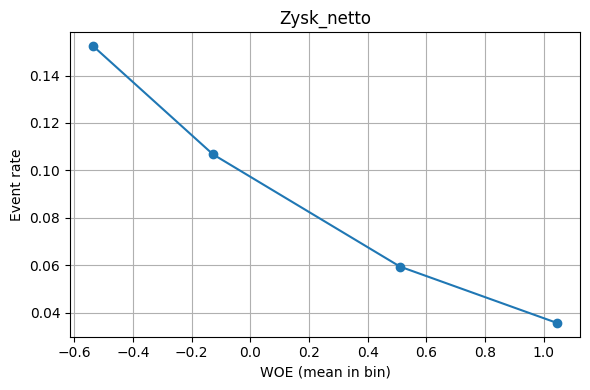

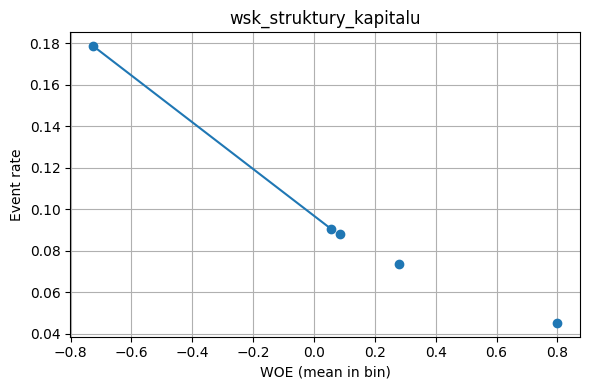

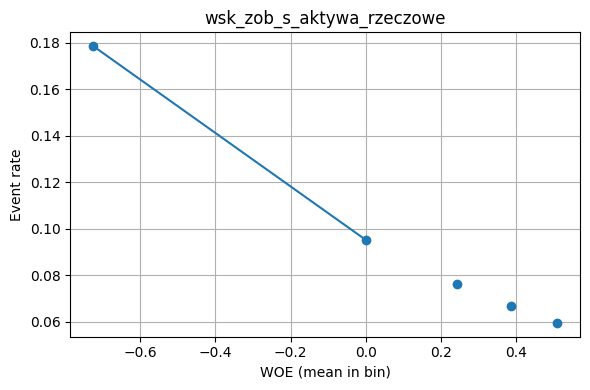

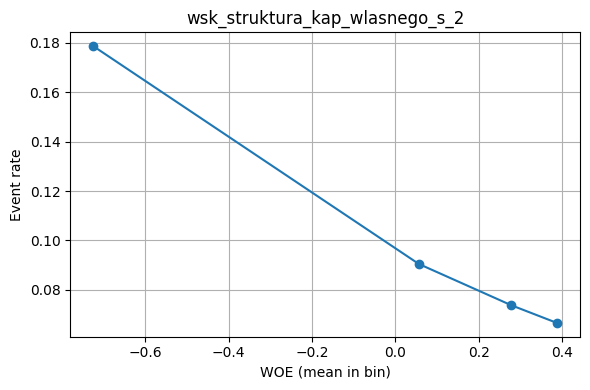

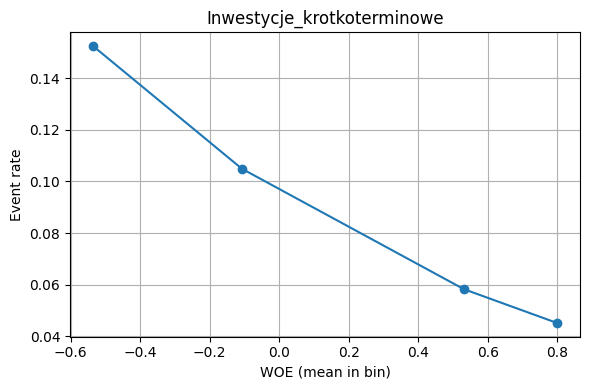

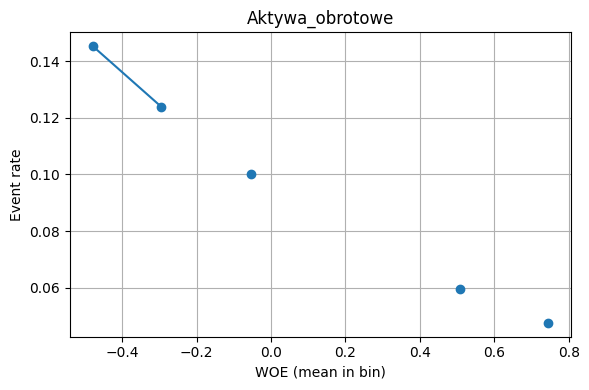

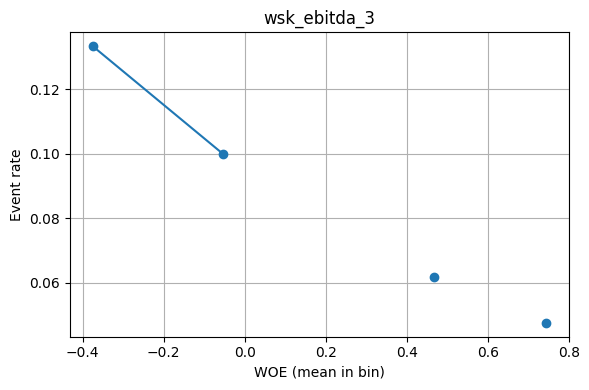

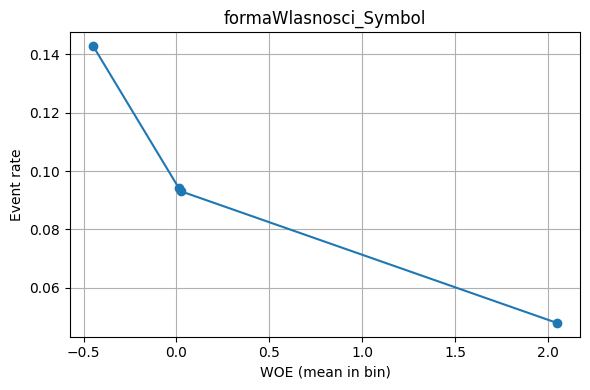

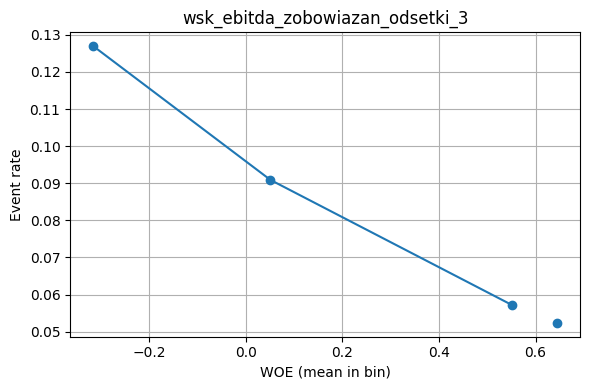

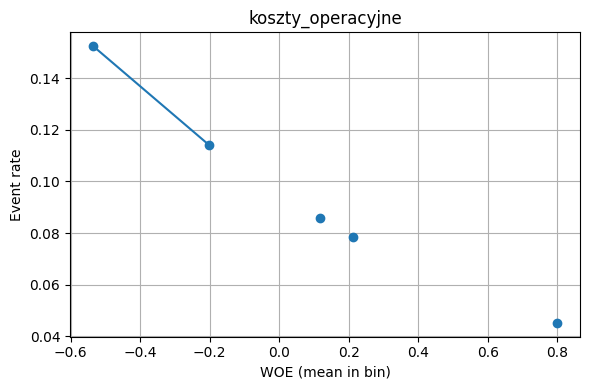

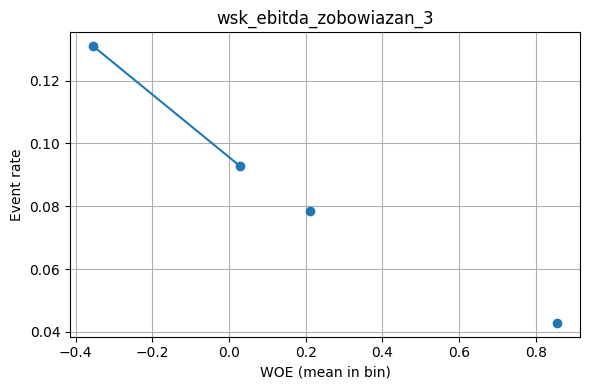

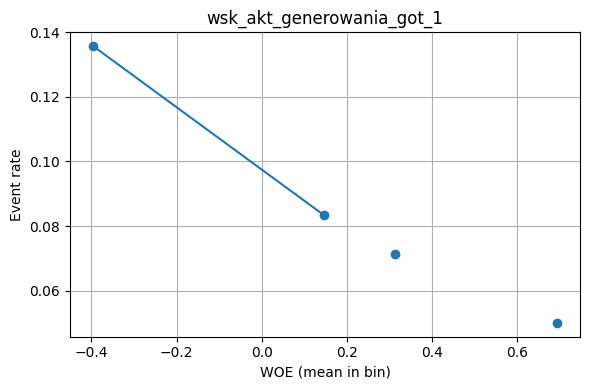

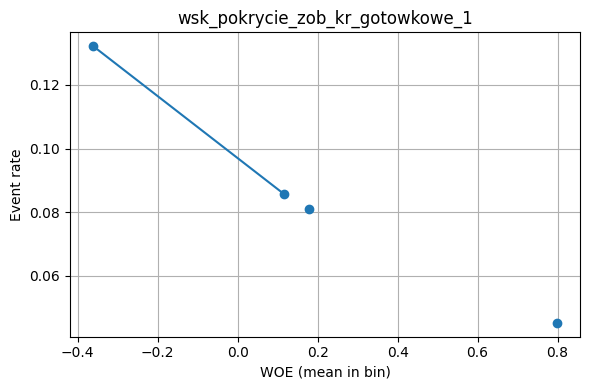

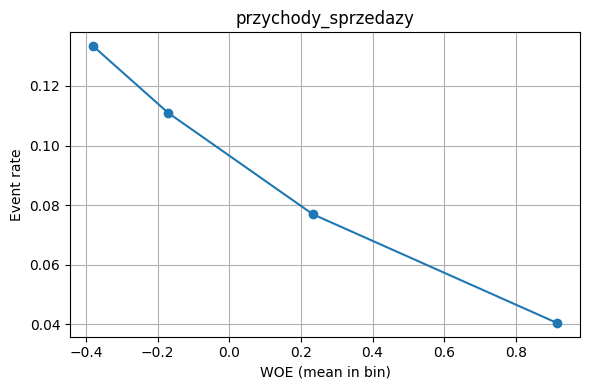

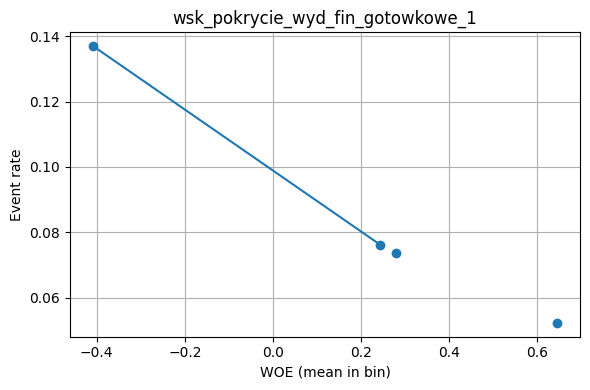

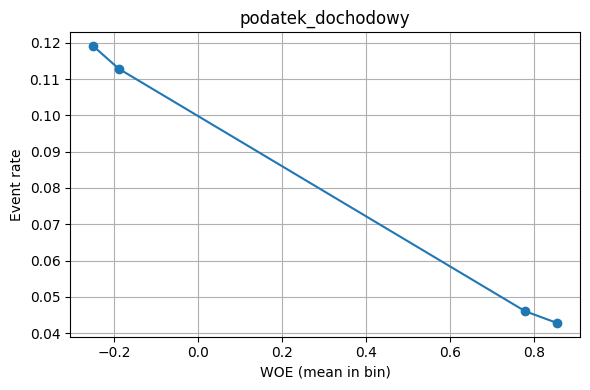

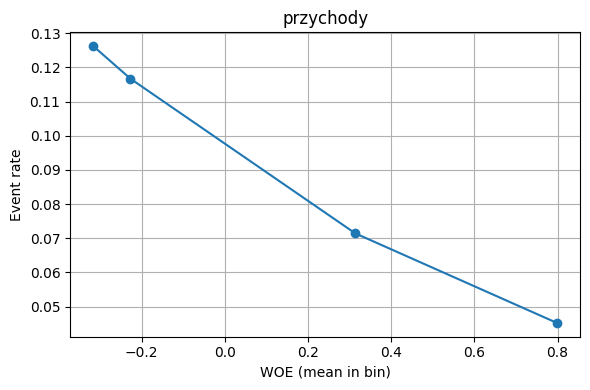

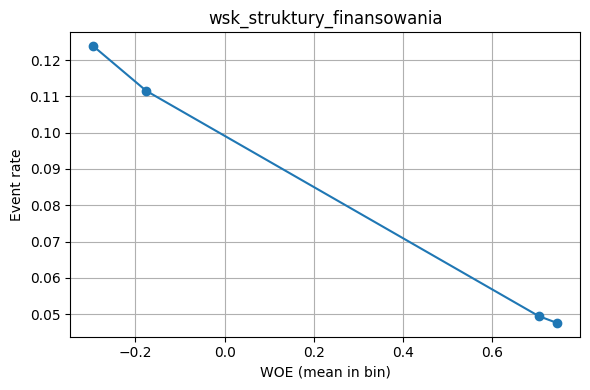

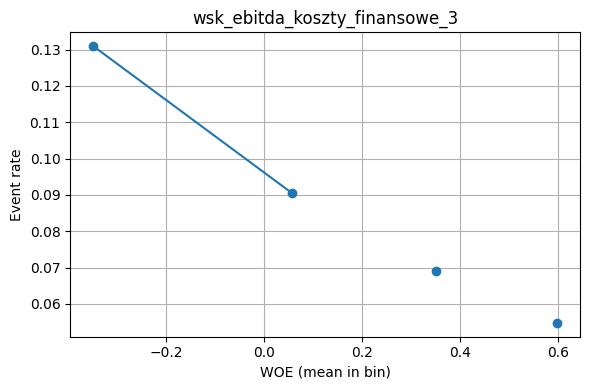

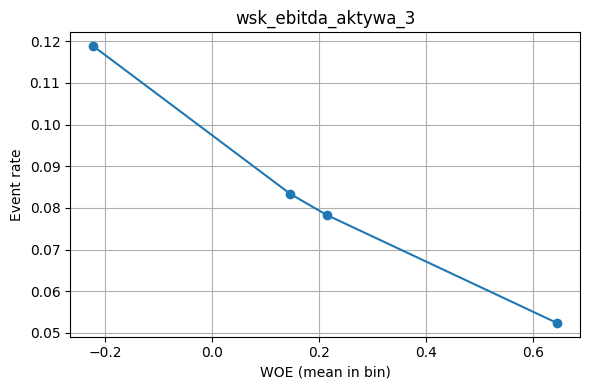

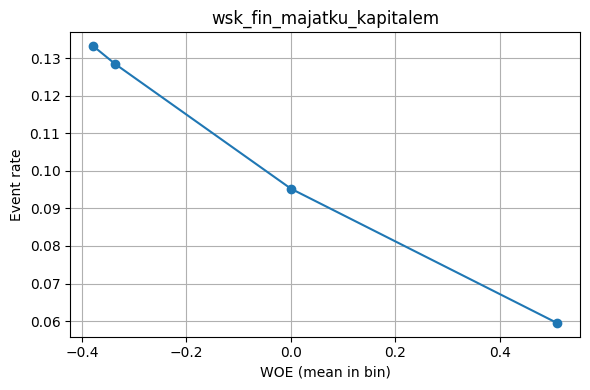

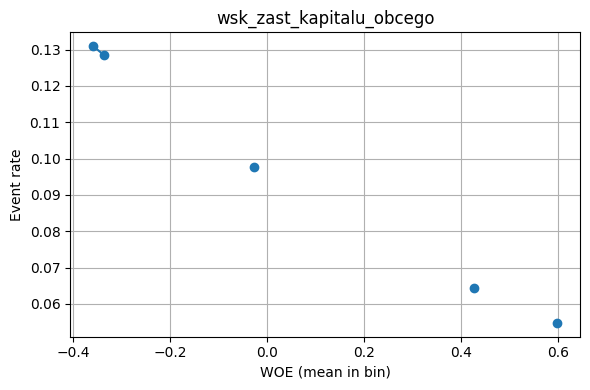

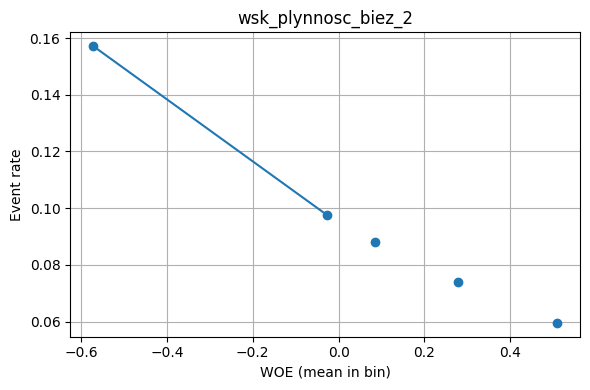

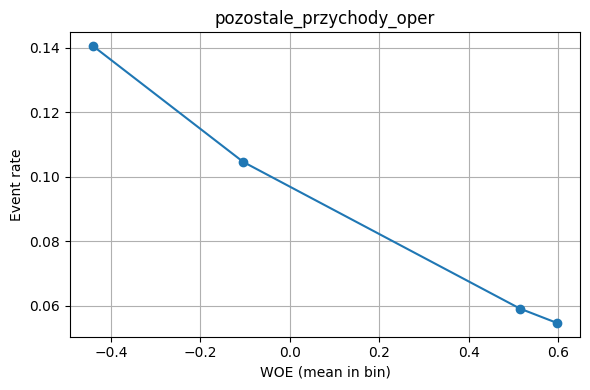

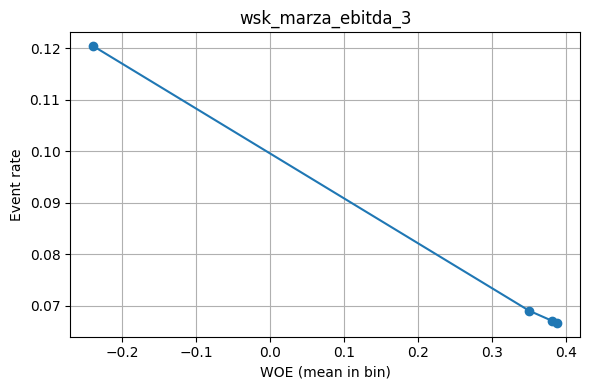

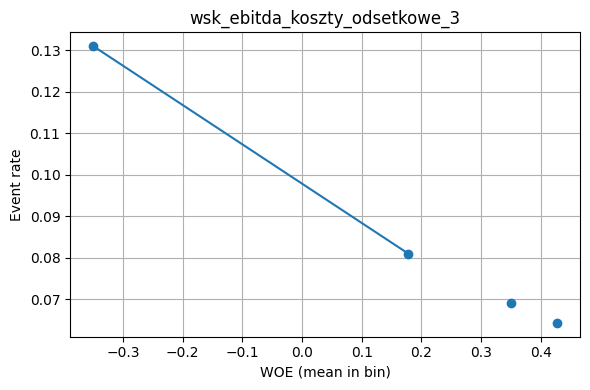

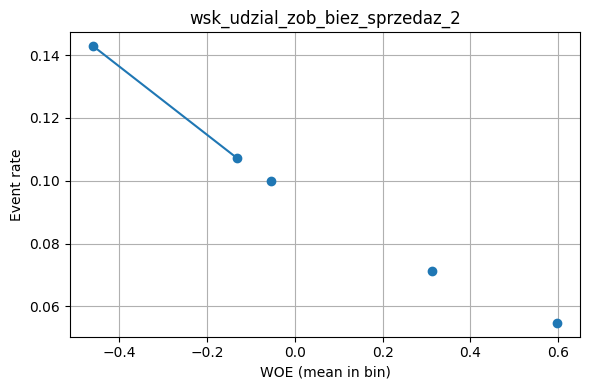

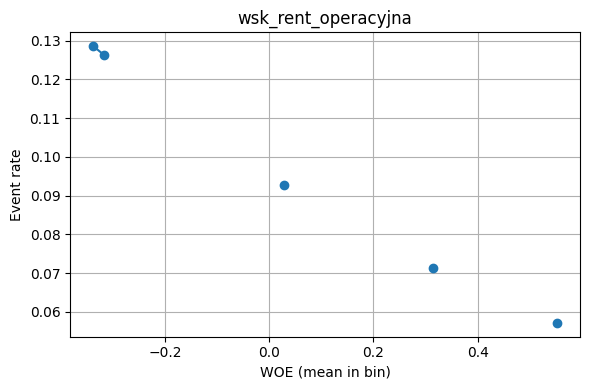

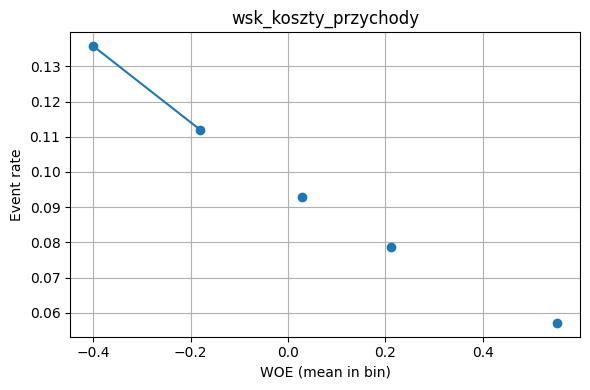

In [279]:
plot_all_woe_monotonicity(X, y)

##### pkdKod ma najmniej liniową zależność 

### Odwracamy znak zmiennych które mają ujemną korelację z targetem

In [280]:
def flip_negative_corr(X, y):
    X_new = X.copy()
    y_series = pd.Series(y)
    for col in X.columns:
        corr = X_new[col].corr(y_series)
        if corr < 0:
            X_new[col] = X_new[col] * -1
    return X_new

In [281]:
X_final = flip_negative_corr(X, y)

In [282]:
X_final

,pkdKod,wsk_poziom_kapitalu_obrotowego_netto,Kapital_wlasny,wsk_mnoznik_kap_wl,wsk_zwrot_aktywa_trwale,wsk_kapital_do_aktywa,Zysk_netto,wsk_struktury_kapitalu,wsk_zob_s_aktywa_rzeczowe,wsk_struktura_kap_wlasnego_s_2,...,wsk_ebitda_aktywa_3,wsk_fin_majatku_kapitalem,wsk_zast_kapitalu_obcego,wsk_plynnosc_biez_2,pozostale_przychody_oper,wsk_marza_ebitda_3,wsk_ebitda_koszty_odsetkowe_3,wsk_udzial_zob_biez_sprzedaz_2,wsk_rent_operacyjna,wsk_koszty_przychody
904,1.557395,0.375301,0.249811,-0.210624,0.054067,-0.210624,0.127189,-0.056542,-0.243976,-0.056542,...,-0.146603,-0.508715,-0.597146,-0.278299,0.439949,-0.381245,-0.350118,-0.313656,-0.552065,-0.210624
1715,-7.875719,-1.364515,-1.044536,-0.313656,0.054067,-0.313656,-1.044536,-0.278299,-0.000000,-0.056542,...,-0.644113,-0.508715,-0.426678,-0.085825,-0.597146,-0.350118,-0.178184,-0.597146,-0.313656,-0.552065
1449,0.253189,-1.364515,-1.044536,-0.313656,0.054067,-0.313656,-1.044536,-0.278299,-0.000000,-0.056542,...,-0.644113,-0.508715,-0.426678,-0.508715,-0.514324,-0.387763,-0.426678,-0.597146,-0.313656,-0.552065
894,-0.616589,0.375301,-0.146603,0.757364,0.105892,0.757364,0.535242,0.725233,0.725233,0.725233,...,-0.146603,0.378185,0.358726,-0.508715,0.104191,-0.350118,0.019934,-0.313656,-0.313656,0.179860
1575,0.379478,-1.364515,-1.044536,-0.210624,-0.027946,-0.210624,-1.044536,-0.056542,-0.508715,-0.387763,...,-0.146603,0.378185,0.358726,-0.278299,-0.597146,-0.350118,-0.350118,0.131028,-0.313656,0.179860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
920,-0.552047,0.179860,0.249811,-0.210624,-0.027946,-0.210624,-0.510202,-0.056542,-0.387763,-0.387763,...,-0.644113,-0.508715,0.337641,-0.278299,-0.514324,-0.387763,-0.178184,-0.597146,-0.313656,-0.552065
2480,0.864906,-0.744435,-0.146603,-0.210624,-0.027946,-0.210624,0.127189,-0.056542,-0.508715,-0.387763,...,-0.115831,-0.508715,-0.597146,0.027328,0.104191,-0.085825,-0.426678,-0.313656,-0.027946,-0.210624
748,0.641764,0.375301,0.249811,-0.210624,0.516689,-0.210624,0.127189,-0.056542,-0.000000,-0.387763,...,0.431557,-0.508715,-0.597146,-0.278299,0.439949,0.440417,0.429835,0.054067,0.316220,0.399939
2866,0.641674,-1.364515,-0.552065,-0.210624,-0.027946,-0.210624,-0.510202,-0.056542,-0.508715,-0.387763,...,-0.146603,-0.508715,-0.597146,-0.508715,-0.514324,-0.387763,-0.350118,0.131028,-0.552065,-0.210624


#### Ostateczne usuwanie skorelowanych kolumn

In [283]:
def drop_correlated_features(X, threshold=0.8):
    corr_matrix = X.corr(numeric_only=True).abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    X_reduced = X.drop(columns=to_drop)
    return X_reduced, to_drop
X_clean, dropped = drop_correlated_features(X_final, threshold=0.8)
print("Usunięte kolumny:", dropped)

Usunięte kolumny: ['wsk_kapital_do_aktywa', 'wsk_struktury_kapitalu', 'wsk_ebitda_zobowiazan_odsetki_3', 'wsk_pokrycie_zob_kr_gotowkowe_1', 'przychody_sprzedazy', 'wsk_pokrycie_wyd_fin_gotowkowe_1', 'przychody', 'wsk_zast_kapitalu_obcego', 'wsk_marza_ebitda_3', 'wsk_ebitda_koszty_odsetkowe_3']


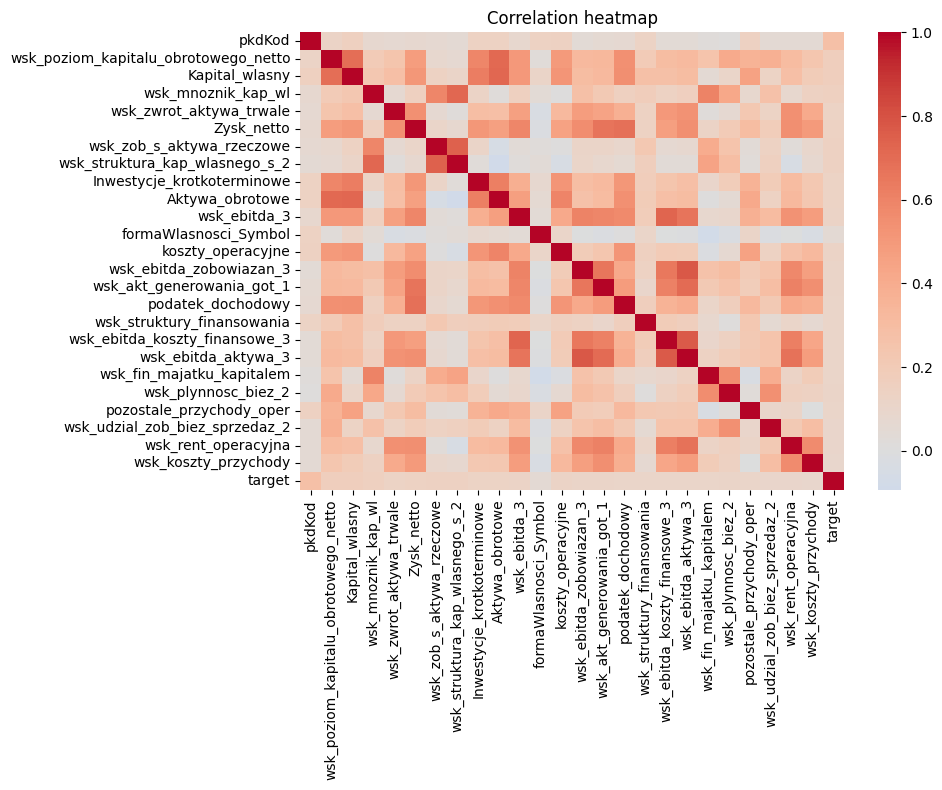

In [284]:
def plot_corr_heatmap(X, y=None):
    df = X.copy()
    if y is not None:
        df['target'] = y
    corr = df.corr(numeric_only=True)
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
    plt.title("Correlation heatmap")
    plt.tight_layout()
    plt.show()
plot_corr_heatmap(X_clean,y)   

In [285]:
# Lista kolumn w kolejności alfabetycznej
columns_sorted = sorted(X_clean.columns.to_list())

# Wyświetlenie
print(columns_sorted)

['Aktywa_obrotowe', 'Inwestycje_krotkoterminowe', 'Kapital_wlasny', 'Zysk_netto', 'formaWlasnosci_Symbol', 'koszty_operacyjne', 'pkdKod', 'podatek_dochodowy', 'pozostale_przychody_oper', 'wsk_akt_generowania_got_1', 'wsk_ebitda_3', 'wsk_ebitda_aktywa_3', 'wsk_ebitda_koszty_finansowe_3', 'wsk_ebitda_zobowiazan_3', 'wsk_fin_majatku_kapitalem', 'wsk_koszty_przychody', 'wsk_mnoznik_kap_wl', 'wsk_plynnosc_biez_2', 'wsk_poziom_kapitalu_obrotowego_netto', 'wsk_rent_operacyjna', 'wsk_struktura_kap_wlasnego_s_2', 'wsk_struktury_finansowania', 'wsk_udzial_zob_biez_sprzedaz_2', 'wsk_zob_s_aktywa_rzeczowe', 'wsk_zwrot_aktywa_trwale']


In [286]:
X_clean=X_clean[sorted(X_clean.columns)]
X_clean

,Aktywa_obrotowe,Inwestycje_krotkoterminowe,Kapital_wlasny,Zysk_netto,formaWlasnosci_Symbol,koszty_operacyjne,pkdKod,podatek_dochodowy,pozostale_przychody_oper,wsk_akt_generowania_got_1,...,wsk_koszty_przychody,wsk_mnoznik_kap_wl,wsk_plynnosc_biez_2,wsk_poziom_kapitalu_obrotowego_netto,wsk_rent_operacyjna,wsk_struktura_kap_wlasnego_s_2,wsk_struktury_finansowania,wsk_udzial_zob_biez_sprzedaz_2,wsk_zob_s_aktywa_rzeczowe,wsk_zwrot_aktywa_trwale
904,0.294451,0.107630,0.249811,0.127189,-0.022419,0.203598,1.557395,0.249811,0.439949,-0.146603,...,-0.210624,-0.210624,-0.278299,0.375301,-0.552065,-0.056542,0.176096,-0.313656,-0.243976,0.054067
1715,-0.508715,-0.798225,-1.044536,-1.044536,0.379485,-0.115831,-7.875719,-0.854782,-0.597146,-0.693142,...,-0.552065,-0.313656,-0.085825,-1.364515,-0.313656,-0.056542,-0.744435,-0.597146,-0.000000,0.054067
1449,-0.508715,-0.798225,-1.044536,-1.044536,-0.022419,-0.798225,0.253189,-0.854782,-0.514324,-0.693142,...,-0.552065,-0.313656,-0.508715,-1.364515,-0.313656,-0.056542,-0.744435,-0.597146,-0.000000,0.054067
894,0.294451,0.535242,-0.146603,0.535242,-0.022419,0.203598,-0.616589,0.188996,0.104191,-0.146603,...,0.179860,0.757364,-0.508715,0.375301,-0.313656,0.725233,0.294451,-0.313656,0.725233,0.105892
1575,-0.508715,-0.798225,-1.044536,-1.044536,0.048527,-0.210624,0.379478,-0.854782,-0.597146,-0.313656,...,0.179860,-0.210624,-0.278299,-1.364515,-0.313656,-0.387763,0.294451,0.131028,-0.508715,-0.027946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
920,0.054067,0.107630,0.249811,-0.510202,-0.022419,-0.210624,-0.552047,0.188996,-0.514324,-0.693142,...,-0.552065,-0.210624,-0.278299,0.179860,-0.313656,-0.387763,-0.744435,-0.597146,-0.387763,-0.027946
2480,0.054067,0.107630,-0.146603,0.127189,-0.022419,-0.210624,0.864906,0.249811,0.104191,-0.146603,...,-0.210624,-0.210624,0.027328,-0.744435,-0.027946,-0.387763,0.294451,-0.313656,-0.508715,-0.027946
748,0.294451,0.107630,0.249811,0.127189,-0.022419,0.535242,0.641764,0.188996,0.439949,-0.146603,...,0.399939,-0.210624,-0.278299,0.375301,0.316220,-0.387763,0.176096,0.054067,-0.000000,0.516689
2866,-0.508715,0.107630,-0.552065,-0.510202,0.379485,-0.210624,0.641674,-0.779516,-0.514324,-0.146603,...,-0.210624,-0.210624,-0.508715,-1.364515,-0.552065,-0.387763,-0.744435,0.131028,-0.508715,-0.027946


In [287]:
X_clean.isna().sum()[X_clean.isna().sum() > 0]

Series([], dtype: int64)

In [288]:
df_all = X_clean.copy()
df_all["_y"] = y.values if hasattr(y, "values") else y

dupe_mask = df_all.duplicated(keep=False)

num_dupes = dupe_mask.sum()

print("Liczba obserwacji będących duplikatami (z tym samym y):", num_dupes)


Liczba obserwacji będących duplikatami (z tym samym y): 28


#### Usuwanie obserwacji, które są duplikatami (dla identycznych etykiet zostawiam jedną, dla różnych etykiet usuwam oba rekordy)

In [289]:
df = X_clean.copy()
df["_y"] = y.values if hasattr(y, "values") else y

unique_y_per_group = df.groupby(list(X_clean.columns))["_y"].transform("nunique")

df_consistent = df[unique_y_per_group == 1]

df_final = df_consistent.drop_duplicates(subset=X_clean.columns, keep="first").reset_index(drop=True)

X_final = df_final.drop(columns="_y")
y_final = df_final["_y"]

print("Początkowa liczba wierszy:", len(df))
print("Liczba po czyszczeniu:", len(df_final))
print("Usunięto wierszy:", len(df) - len(df_final))


Początkowa liczba wierszy: 2100
Liczba po czyszczeniu: 2084
Usunięto wierszy: 16


### Analiza zawartości binów

In [290]:
EPS = 1e-10

def analyze_woe_bins(X_woe, y,
                     min_bin_size=30,
                     woe_threshold=3.0,
                     iv_share_thresh=0.25,
                     spearman_thresh=0.8,
                     order_by='woe'):
    y = pd.Series(y).reset_index(drop=True)
    total_events = y.sum()
    total_non_events = (1 - y).sum()

    profiles = {}
    summary_rows = []

    for feature in X_woe.columns:
        ser = X_woe[feature].reset_index(drop=True)
        df = pd.DataFrame({feature: ser, '_y': y}).dropna()

        grp = df.groupby(feature)['_y'].agg(n='count', events='sum').reset_index().rename(columns={feature:'woe_value'})
        if grp.shape[0] == 0:
            continue

        grp['non_events'] = grp['n'] - grp['events']
        grp['event_rate'] = grp['events'] / grp['n']
        grp['event_dist'] = grp['events'] / (total_events)
        grp['non_event_dist'] = grp['non_events'] / (total_non_events)
        grp['prop_of_population'] = grp['n'] / (grp['n'].sum() + EPS)
        grp['woe'] = grp['woe_value'].astype(float)
        grp['iv_contrib'] = (grp['non_event_dist'] - grp['event_dist']) * grp['woe']

        if order_by == 'woe':
            grp = grp.sort_values('woe').reset_index(drop=True)
        elif order_by == 'event_rate':
            grp = grp.sort_values('event_rate').reset_index(drop=True)
        else:
            grp = grp.reset_index(drop=True)

        grp['cum_event_dist'] = grp['event_dist'].cumsum()
        grp['cum_non_event_dist'] = grp['non_event_dist'].cumsum()
        grp['ks'] = (grp['cum_non_event_dist'] - grp['cum_event_dist']).abs()
        grp['cum_iv'] = grp['iv_contrib'].cumsum()

        total_iv = grp['iv_contrib'].sum()

        try:
            spearman = spearmanr(grp['woe'], np.arange(len(grp)))[0]
        except Exception:
            spearman = np.nan

        grp['flag_small_bin'] = grp['n'] < min_bin_size
        grp['flag_zero_events'] = grp['events'] == 0
        grp['flag_zero_non_events'] = grp['non_events'] == 0
        grp['flag_extreme_woe'] = grp['woe'].abs() > woe_threshold
        grp['iv_share'] = 0.0 if abs(total_iv) < EPS else grp['iv_contrib'] / total_iv
        grp['flag_big_iv_share'] = grp['iv_share'].abs() > iv_share_thresh

        profiles[feature] = grp

        n_bins = grp.shape[0]
        n_small = int(grp['flag_small_bin'].sum())
        n_zero_events = int(grp['flag_zero_events'].sum())
        n_zero_non = int(grp['flag_zero_non_events'].sum())
        n_extreme = int(grp['flag_extreme_woe'].sum())
        n_big_iv = int(grp['flag_big_iv_share'].sum())
        max_ks = float(grp['ks'].max())
        max_iv_share = float(grp['iv_share'].abs().max())
        non_monotonic_flag = (abs(spearman) < spearman_thresh) if not np.isnan(spearman) else True

        summary_rows.append({
            'feature': feature,
            'n_bins': n_bins,
            'total_iv': total_iv,
            'spearman': spearman,
            'non_monotonic': non_monotonic_flag,
            'n_small_bins': n_small,
            'n_bins_zero_events': n_zero_events,
            'n_bins_zero_non_events': n_zero_non,
            'n_extreme_woe_bins': n_extreme,
            'n_big_iv_bins': n_big_iv,
            'max_ks': max_ks,
            'max_iv_share': max_iv_share,
            'prop_pop_min': float(grp['prop_of_population'].min()),
            'prop_pop_max': float(grp['prop_of_population'].max())
        })

    summary = pd.DataFrame(summary_rows).sort_values('total_iv', ascending=False).reset_index(drop=True)
    return profiles, summary


In [291]:
profiles, summary = analyze_woe_bins(X_final, y_final)

In [292]:
summary

,feature,n_bins,total_iv,spearman,non_monotonic,n_small_bins,n_bins_zero_events,n_bins_zero_non_events,n_extreme_woe_bins,n_big_iv_bins,max_ks,max_iv_share,prop_pop_min,prop_pop_max
0,wsk_koszty_przychody,5,-0.102228,1.0,False,0,0,0,0,2,0.132162,0.483202,0.193858,0.201536
1,wsk_rent_operacyjna,5,-0.116884,1.0,False,0,0,0,0,1,0.151761,0.422613,0.193858,0.201536
2,wsk_udzial_zob_biez_sprzedaz_2,5,-0.130299,1.0,False,0,0,0,0,2,0.151175,0.435524,0.195777,0.201536
3,pozostale_przychody_oper,4,-0.139792,1.0,False,0,0,0,0,2,0.156304,0.405947,0.145873,0.451056
4,wsk_plynnosc_biez_2,5,-0.141827,1.0,False,0,0,0,0,2,0.151482,0.588392,0.196257,0.201536
5,wsk_fin_majatku_kapitalem,4,-0.145486,1.0,False,0,0,0,0,1,0.167618,0.585032,0.190499,0.402591
6,wsk_ebitda_aktywa_3,5,-0.147313,1.0,False,0,0,0,0,2,0.167602,0.490994,0.079655,0.315739
7,wsk_ebitda_koszty_finansowe_3,5,-0.150851,1.0,False,0,0,0,0,2,0.168428,0.476052,0.079175,0.316219
8,wsk_struktury_finansowania,4,-0.156104,1.0,False,0,0,0,0,1,0.163305,0.532675,0.096929,0.500480
9,podatek_dochodowy,4,-0.171962,1.0,False,0,0,0,0,1,0.164558,0.610460,0.072937,0.523992


#### pkdKod oraz forma własności mogą powodować overfitting - warto się im przyjrzeć - mają małe grupy (niektóre)

In [313]:
def greedy_merge_categories(X, y, col, min_count=30):
    df = pd.DataFrame({col: X[col].astype(object), '_y': y.values})
    stats = df.groupby(col)['_y'].agg(n='count', events='sum').reset_index()
    stats['rate'] = stats['events'] / (stats['n'] + EPS)
    stats = stats.sort_values('rate').reset_index(drop=True)
    
    groups = []
    for _, r in stats.iterrows():
        groups.append({'cats': [r[col]], 'n': int(r['n']), 'events': int(r['events']), 'rate': float(r['rate'])})

    def merge_groups(i, j):
        gi, gj = groups[i], groups[j]
        new_n = gi['n'] + gj['n']
        new_events = gi['events'] + gj['events']
        new_rate = new_events / (new_n + EPS)
        new_cats = gi['cats'] + gj['cats']
        groups[i] = {'cats': new_cats, 'n': new_n, 'events': new_events, 'rate': new_rate}
        groups.pop(j)

    while True:
        groups = sorted(groups, key=lambda g: g['rate'])
        small_idx = None
        for idx, g in enumerate(groups):
            if g['n'] < min_count:
                small_idx = idx
                break
        if small_idx is None:
            break
        if small_idx == 0:
            neighbor = 1
        elif small_idx == len(groups) - 1:
            neighbor = small_idx - 1
        else:
            left_diff = abs(groups[small_idx]['rate'] - groups[small_idx - 1]['rate'])
            right_diff = abs(groups[small_idx]['rate'] - groups[small_idx + 1]['rate'])
            neighbor = small_idx - 1 if left_diff <= right_diff else small_idx + 1
        i, j = min(small_idx, neighbor), max(small_idx, neighbor)
        merge_groups(i, j)

    mapping = {}
    for gi in groups:
        label = '|'.join(map(str, gi['cats']))
        for c in gi['cats']:
            mapping[c] = label

    X2 = X.copy()
    X2[col + '_merged'] = X2[col].map(mapping)
    X2.drop(col, axis=1, inplace=True)
    return X2, mapping, groups

In [321]:
X_merged, mapping, groups = greedy_merge_categories(X = X_final, y = y_final, col = 'pkdKod')
X_merged, mapping, groups = greedy_merge_categories(X_merged, y_final, col = 'formaWlasnosci_Symbol')

In [322]:
y_merged = y_final

In [323]:
def calc_woe(col):
        alpha = 1

        stats = (X_merged.assign(_y=y_merged)
                .groupby(col)['_y']
                .agg(n='count', events='sum')
                .reset_index())
        stats['non'] = stats['n'] - stats['events']

        tot_e = stats['events'].sum()
        tot_ne = stats['non'].sum()
        m = len(stats)

        ev_share = (stats['events'] + alpha) / (tot_e + alpha * m)
        ne_share = (stats['non'] + alpha) / (tot_ne + alpha * m)
        stats['woe'] = np.log(ev_share / ne_share)

        mp = dict(zip(stats[col], stats['woe']))
        X_merged[col] = X_merged[col].map(mp)

In [324]:
calc_woe("pkdKod_merged")
calc_woe("formaWlasnosci_Symbol_merged")

In [325]:
len(X_merged.columns)

25

In [326]:
profile, summary = analyze_woe_bins(X_merged, y_merged)

In [327]:
summary

,feature,n_bins,total_iv,spearman,non_monotonic,n_small_bins,n_bins_zero_events,n_bins_zero_non_events,n_extreme_woe_bins,n_big_iv_bins,max_ks,max_iv_share,prop_pop_min,prop_pop_max
0,formaWlasnosci_Symbol_merged,9,-0.061523,1.0,False,0,1,0,0,2,0.060275,0.335959,0.014875,0.661708
1,wsk_koszty_przychody,5,-0.102228,1.0,False,0,0,0,0,2,0.132162,0.483202,0.193858,0.201536
2,wsk_rent_operacyjna,5,-0.116884,1.0,False,0,0,0,0,1,0.151761,0.422613,0.193858,0.201536
3,wsk_udzial_zob_biez_sprzedaz_2,5,-0.130299,1.0,False,0,0,0,0,2,0.151175,0.435524,0.195777,0.201536
4,pozostale_przychody_oper,4,-0.139792,1.0,False,0,0,0,0,2,0.156304,0.405947,0.145873,0.451056
5,wsk_plynnosc_biez_2,5,-0.141827,1.0,False,0,0,0,0,2,0.151482,0.588392,0.196257,0.201536
6,wsk_fin_majatku_kapitalem,4,-0.145486,1.0,False,0,0,0,0,1,0.167618,0.585032,0.190499,0.402591
7,wsk_ebitda_aktywa_3,5,-0.147313,1.0,False,0,0,0,0,2,0.167602,0.490994,0.079655,0.315739
8,wsk_ebitda_koszty_finansowe_3,5,-0.150851,1.0,False,0,0,0,0,2,0.168428,0.476052,0.079175,0.316219
9,wsk_struktury_finansowania,4,-0.156104,1.0,False,0,0,0,0,1,0.163305,0.532675,0.096929,0.500480


#### Forma własności straciła moc predykcyjną, więc raczej trzeba ją usunąć.
#### pkdKod nadal ma nadzwyczaj wysokie IV, więc można pomyśleć o zwiększeniu minimalnej liczności binu w jej przypadku.